<a href="https://colab.research.google.com/github/MatthewSebastian15/Automated-Portfolio-Management/blob/main/Indonesian_Blue_Chip_Stocks/Model%20%26%20Result.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Automated Portfolio Management**
## **(ADRO, AMRT, ASII, BBCA, BBNI, BBRI, BMRI, ICBP, ISAT, MDKA, MYOR, TLKM)**

In [ ]:
# VOLUME: Filter saham yang nilai transaksinya > 10 Miliar/hari
# BIAYA: Potong biaya beli (0.19%) & jual (0.29% - ada pajak BEI)
# RISIKO: Pakai CVaR (Lebih aman kalau pasar tiba-tiba ambrol)
# ATURAN: Rebalance hanya jika bobot berubah di atas 5% (Biar hemat fee)

# Equal Weight : dibuatkan tetap menggunakan 12 saham, dalam portonya tetap 10 dengan pembagian rata. Tidak hanya menamsukan 10 saham yang konstan saja tetapi tetap menggunakan 12 saham yang ada

# Hapus saham yang sepi (transaksi harian di bawah 10 Miliar)
# nilai_transaksi = prices * volumes
# saham_layak = nilai_transaksi.mean() > 10_000_000_000
# prices = prices.loc[:, saham_layak]

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import FuncFormatter
import matplotlib.dates as mdates
import plotly.graph_objects as go
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, Model, callbacks
from scipy.optimize import minimize
from datetime import datetime, timedelta

In [ ]:
TICKERS = [
    'ADRO.JK',  # PT Adaro Energy Indonesia Tbk
    'AMRT.JK',  # PT Sumber Alfaria Trijaya Tbk
    'ASII.JK',  # PT Astra International Tbk
    'BBCA.JK',  # PT Bank Central Asia Tbk
    'BBNI.JK',  # PT Bank Negara Indonesia (Persero) Tbk
    'BBRI.JK',  # PT Bank Rakyat Indonesia (Persero) Tbk
    'BMRI.JK',  # PT Bank Mandiri (Persero) Tbk
    'ICBP.JK',  # PT Indofood CBP Sukses Makmur Tbk
    'ISAT.JK',  # PT Indosat Ooredoo Hutchison Tbk
    'MDKA.JK',  # PT Merdeka Copper Gold Tbk
    'MYOR.JK',  # PT Mayora Indah Tbk
    'TLKM.JK'   # PT Telkom Indonesia (Persero) Tbk
]

START_DATE = '2006-01-01'
END_DATE = '2025-12-31'

In [ ]:
# LOAD DATA
def load_data(tickers, start, end):
    raw_data = yf.download(tickers, start=start, end=end, auto_adjust=True)
    prices = raw_data['Close'].ffill().bfill()
    volumes = raw_data['Volume'].ffill().bfill()
    log_returns = np.log(prices / prices.shift(1)).dropna()
    return prices.loc[log_returns.index], volumes.loc[log_returns.index], log_returns

prices, volumes, log_returns = load_data(TICKERS, START_DATE, END_DATE)

[*********************100%***********************]  12 of 12 completed


In [ ]:
LOOKBACK_WINDOW = 60
FORWARD_DAYS = 5
ROLLING_SCALER_DAYS = 756
MV_LOOKBACK_DAYS = 756
REBALANCE_FREQ = 'ME'


# FEATURE ENGINEERING
def create_features(returns, volumes, prices):
    feats = []
    for t in returns.columns:
        ret = returns[t]
        vol_data = volumes[t]
        price_data = prices[t]

        vol = ret.rolling(20).std()
        mom1 = ret.rolling(20).mean()

        typical_price = price_data
        money_flow = typical_price * vol_data
        delta_tp = typical_price.diff()

        pos_flow = (money_flow.where(delta_tp > 0, 0)).rolling(14).sum()
        neg_flow = (money_flow.where(delta_tp < 0, 0)).rolling(14).sum()
        mfi = 100 - (100 / (1 + (pos_flow / (neg_flow + 1e-8))))

        obv = (np.sign(price_data.diff()) * vol_data).fillna(0).cumsum()
        obv_change = obv.pct_change(20).replace([np.inf, -np.inf], 0).fillna(0)

        f = pd.concat([
            ret.rename(f"{t}_ret"),
            vol.rename(f"{t}_vol"),
            mom1.rename(f"{t}_mom1m"),
            mfi.rename(f"{t}_mfi"),
            obv_change.rename(f"{t}_obv_chg")
        ], axis=1)

        feats.append(f)

    X = pd.concat(feats, axis=1).dropna()
    y = returns.loc[X.index]
    return X, y

X_raw, y_raw = create_features(log_returns, volumes, prices)


# MODEL ARCHITECTURE
class AttentionLayer(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight",shape=(input_shape[-1], 1),initializer="glorot_uniform")
        self.b = self.add_weight(name="att_bias",shape=(input_shape[1], 1),initializer="zeros")
        super().build(input_shape)

    def call(self, x):
        et = tf.squeeze(tf.tanh(tf.matmul(x, self.W) + self.b), axis=-1)
        at = tf.nn.softmax(et)
        at = tf.expand_dims(at, axis=-1)
        return tf.reduce_sum(x * at, axis=1)

def sharpe_loss(y_true, y_pred):
    portfolio_ret = tf.reduce_sum(y_pred * y_true, axis=-1)
    mean_ret = tf.reduce_mean(portfolio_ret)
    std_ret = tf.math.reduce_std(portfolio_ret) + 1e-4
    return -(mean_ret / std_ret)

def build_model(input_shape, n_assets):
    inp = layers.Input(shape=input_shape)
    x = layers.LSTM(64, return_sequences=True)(inp)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.LSTM(32, return_sequences=True)(x)
    x = AttentionLayer()(x)
    x = layers.Dense(16, activation="relu")(x)
    out = layers.Dense(n_assets, activation="linear")(x)
    model = Model(inp, out)
    model.compile(optimizer=tf.keras.optimizers.Adam(0.001),loss=sharpe_loss)
    return model


# OPTIMIZATION UTILITIES
def get_sequences_forward(X, y, window, fwd):
    Xs, ys = [], []
    for i in range(len(X) - window - fwd):
        Xs.append(X.iloc[i:i + window].values)
        ys.append(y.iloc[i + window:i + window + fwd].mean().values)
    return np.array(Xs), np.array(ys)

def optimize_weights(mu, cov):
    n = len(mu)
    if n == 0:
        return np.array([])

    init_w = np.ones(n) / n
    res = minimize(lambda w: -(np.dot(mu, w) / (np.sqrt(np.dot(w.T, np.dot(cov, w))) + 1e-8)),init_w,bounds=[(0, 1)] * n,constraints=({"type": "eq", "fun": lambda w: np.sum(w) - 1}))
    return res.x if res.success else init_w

def softmax_dynamic(x, ticker_names, current_features,min_assets=6, max_assets=8,min_weight=0.05, max_weight=0.25):
    scores = np.nan_to_num(x, nan=0.0)

    for i, t in enumerate(ticker_names):
        if current_features.get(f"{t}_mfi", 50) > 80:
            scores[i] -= 2.0
        if current_features.get(f"{t}_obv_chg", 0) < 0:
            scores[i] -= 1.0

    e = np.exp(scores - np.max(scores))
    w_raw = e / (e.sum() + 1e-8)
    n_keep = int(np.clip(np.sum(w_raw > np.mean(w_raw)),min_assets,max_assets))
    top_idx = np.argsort(w_raw)[::-1][:n_keep]
    w = np.zeros_like(w_raw)
    w[top_idx] = w_raw[top_idx]

    for _ in range(100):
        w = w / (w.sum() + 1e-8)
        w[top_idx] = np.clip(w[top_idx], min_weight, max_weight)
        w[~np.isin(np.arange(len(w)), top_idx)] = 0.0

    active = np.where(w > 0)[0]

    if len(active) < min_assets:
        add_idx = np.argsort(w_raw)[::-1]
        for i in add_idx:
            if i not in active:
                w[i] = min_weight
                active = np.where(w > 0)[0]
            if len(active) >= min_assets:
                break

    w = w / (w.sum() + 1e-8)
    return w

In [ ]:
years = sorted(X_raw.index.year.unique())
test_years = [y for y in years if y >= 2016]

ew_weights = np.zeros(len(TICKERS))
portfolio_values = {"Model": [], "EqualWeight": [], "MeanVariance": []}

dates_history = []
weights_history = []
raw_weights_history = []
mv_weights_history = []

model_capital = ew_capital = mv_capital = 1.0

for year in test_years:
    print(f"Processing Year: {year}")

    train_mask = X_raw.index.year < year
    test_mask = X_raw.index.year == year
    X_train = X_raw[train_mask]
    y_train = y_raw[train_mask]
    X_test = X_raw[test_mask]
    mu_tr = X_train.tail(ROLLING_SCALER_DAYS).mean()
    std_tr = X_train.tail(ROLLING_SCALER_DAYS).std()
    X_all_s = (X_raw - mu_tr) / (std_tr + 1e-8)
    X_seq, y_seq = get_sequences_forward(X_all_s.loc[X_train.index],y_train,LOOKBACK_WINDOW,FORWARD_DAYS)
    model = build_model((LOOKBACK_WINDOW, X_raw.shape[1]),len(TICKERS))

    model.fit(
        X_seq,
        y_seq,
        epochs=25,
        batch_size=32,
        verbose=0,
        callbacks=[callbacks.EarlyStopping(monitor="loss", patience=3)]
    )

    for _, X_month in X_test.groupby(pd.Grouper(freq=REBALANCE_FREQ)):
        if len(X_month) == 0:
            continue

        ew_weights = np.zeros(len(TICKERS))
        hist_ew = y_raw.loc[y_raw.index < X_month.index[0]].tail(60)

        if len(hist_ew) > 0:
            score_ew = hist_ew.mean()
            ranked_idx = np.argsort(score_ew.values)[::-1]
            top10_idx = ranked_idx[:10]
            ew_weights[top10_idx] = 1.0 / 10
        else:
            ew_weights[:10] = 1.0 / 10

        try:
            idx = X_all_s.index.get_loc(X_month.index[0])
            input_seq = X_all_s.iloc[idx - LOOKBACK_WINDOW:idx].values
            current_feats = X_raw.loc[X_month.index[0]]
            preds = model.predict(input_seq.reshape(1, LOOKBACK_WINDOW, -1),verbose=0)[0]
            raw_weights_history.append(preds.copy())
            model_w = softmax_dynamic(preds, TICKERS, current_feats)

        except:
            model_w = ew_weights.copy()

        try:
            hist = y_raw.loc[y_raw.index < X_month.index[0]].tail(MV_LOOKBACK_DAYS)
            mu_mv = hist.mean() * 252
            flex_idx = np.argsort(mu_mv.values)[-7:]
            w_mv_opt = optimize_weights(mu_mv.iloc[flex_idx].values,hist.iloc[:, flex_idx].cov().values * 252)
            mv_w = np.zeros(len(TICKERS))
            mv_w[flex_idx] = w_mv_opt

        except:
            mv_w = ew_weights.copy()

        for date in X_month.index:
            d_ret = np.exp(y_raw.loc[date].values) - 1
            model_capital *= (1 + np.dot(model_w, d_ret))
            ew_capital *= (1 + np.dot(ew_weights, d_ret))
            mv_capital *= (1 + np.dot(mv_w, d_ret))
            portfolio_values["Model"].append(model_capital)
            portfolio_values["EqualWeight"].append(ew_capital)
            portfolio_values["MeanVariance"].append(mv_capital)
            dates_history.append(date)
            weights_history.append(model_w.copy())
            mv_weights_history.append(mv_w.copy())

Processing Year: 2016
Processing Year: 2017
Processing Year: 2018
Processing Year: 2019
Processing Year: 2020
Processing Year: 2021
Processing Year: 2022
Processing Year: 2023
Processing Year: 2024
Processing Year: 2025


# **Result Model , Equal Weight & Mean Variance**

In [ ]:
results_df = pd.DataFrame(portfolio_values, index=pd.to_datetime(dates_history))
results_df = results_df.loc[~results_df.index.duplicated(keep='last')].sort_index()
weights_df = pd.DataFrame(weights_history, index=pd.to_datetime(dates_history), columns=TICKERS)
weights_df = weights_df.loc[~weights_df.index.duplicated(keep='last')].sort_index()
mv_weights_df = pd.DataFrame(mv_weights_history, index=pd.to_datetime(dates_history), columns=TICKERS)
mv_weights_df = mv_weights_df.loc[~mv_weights_df.index.duplicated(keep='last')].sort_index()

def calculate_performance_metrics(equity_curve):
    equity_curve = equity_curve.dropna()
    if len(equity_curve) < 2: return [np.nan] * 5

    total_return = equity_curve.iloc[-1] / equity_curve.iloc[0] - 1
    days = (equity_curve.index[-1] - equity_curve.index[0]).days
    annual_return = (1 + total_return) ** (365 / max(days, 1)) - 1
    daily_returns = equity_curve.pct_change().dropna()
    annual_vol = daily_returns.std() * np.sqrt(252)
    sharpe = annual_return / (annual_vol + 1e-8)
    rolling_max = equity_curve.cummax()
    drawdown = (equity_curve - rolling_max) / rolling_max
    max_dd = drawdown.min()
    return [total_return * 100, annual_return * 100, annual_vol * 100, sharpe, max_dd * 100]

metrics_table = pd.DataFrame(
    {
        "Deep Learning (Improved)": calculate_performance_metrics(results_df["Model"]),
        "Equal Weight": calculate_performance_metrics(results_df["EqualWeight"]),
        "Mean Variance": calculate_performance_metrics(results_df["MeanVariance"])
    },
    index=["Total Return (%)", "Annualized Return (%)", "Annualized Volatility (%)", "Sharpe Ratio", "Max Drawdown (%)"]
).round(2)

print(metrics_table)

                           Deep Learning (Improved)  Equal Weight  \
Total Return (%)                             404.67        262.05   
Annualized Return (%)                         17.58         13.74   
Annualized Volatility (%)                     21.20         19.09   
Sharpe Ratio                                   0.83          0.72   
Max Drawdown (%)                             -38.03        -39.59   

                           Mean Variance  
Total Return (%)                  367.18  
Annualized Return (%)              16.68  
Annualized Volatility (%)          24.72  
Sharpe Ratio                        0.67  
Max Drawdown (%)                  -35.16  


## **Cumulative Returns**

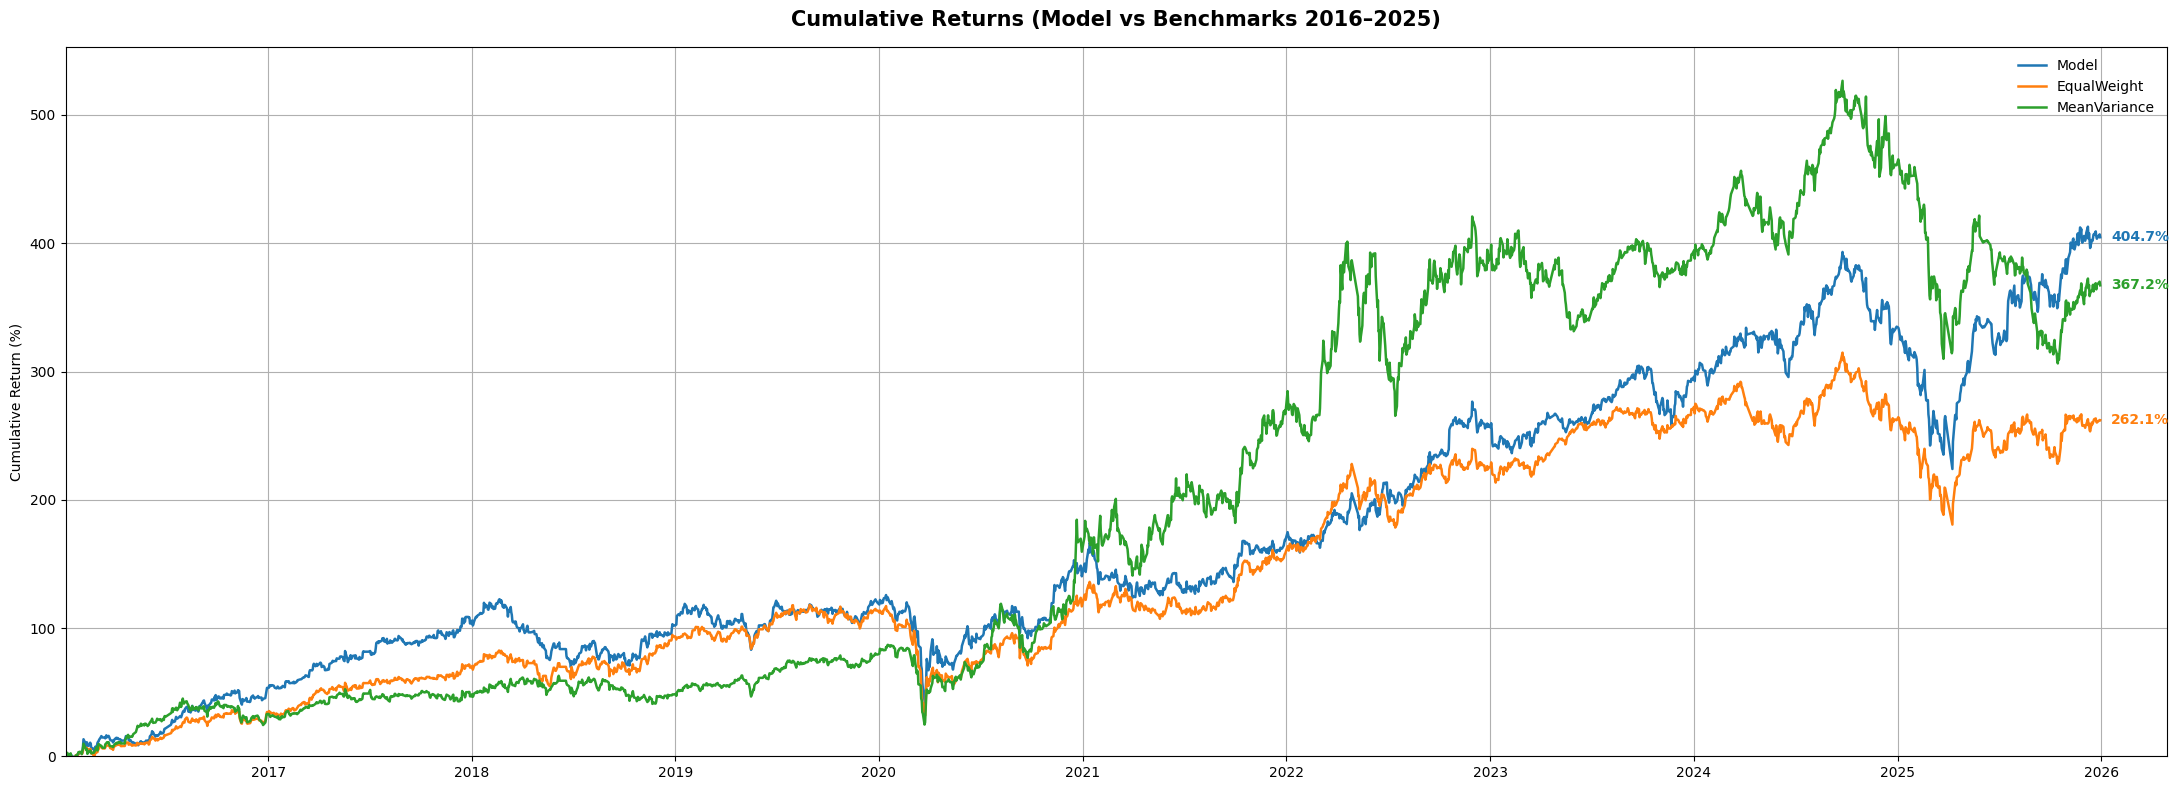

In [ ]:
cumulative_returns_pct = (results_df / results_df.iloc[0] - 1) * 100
fig, ax = plt.subplots(figsize=(22, 8))

colors = {
    'Model': '#1f77b4',
    'EqualWeight': '#ff7f0e',
    'MeanVariance': '#2ca02c'
}

styles = {
    'Model': '-',
    'EqualWeight': '-',
    'MeanVariance': '-'
}

for col in cumulative_returns_pct.columns:
    ax.plot(cumulative_returns_pct.index,cumulative_returns_pct[col],label=col,linewidth=1.8,linestyle=styles[col],color=colors[col])

last_x = cumulative_returns_pct.index[-1]
offset = pd.Timedelta(days=20)

for col in cumulative_returns_pct.columns:
    y = cumulative_returns_pct[col].iloc[-1]
    ax.text(last_x + offset,y,f"{y:.1f}%",va='center',fontsize=10,fontweight='bold',color=colors[col])

ax.set_title('Cumulative Returns (Model vs Benchmarks 2016–2025)',fontsize=15,pad=15,fontweight='bold')
ax.set_ylabel('Cumulative Return (%)')
ax.legend(frameon=False)
ax.grid(True)
ax.set_ylim(bottom=0)
ax.set_xlim(cumulative_returns_pct.index[0],cumulative_returns_pct.index[-1] + pd.Timedelta(days=120))
plt.tight_layout()
plt.show()

## **Yearly Sharpe Ratio Comparison**

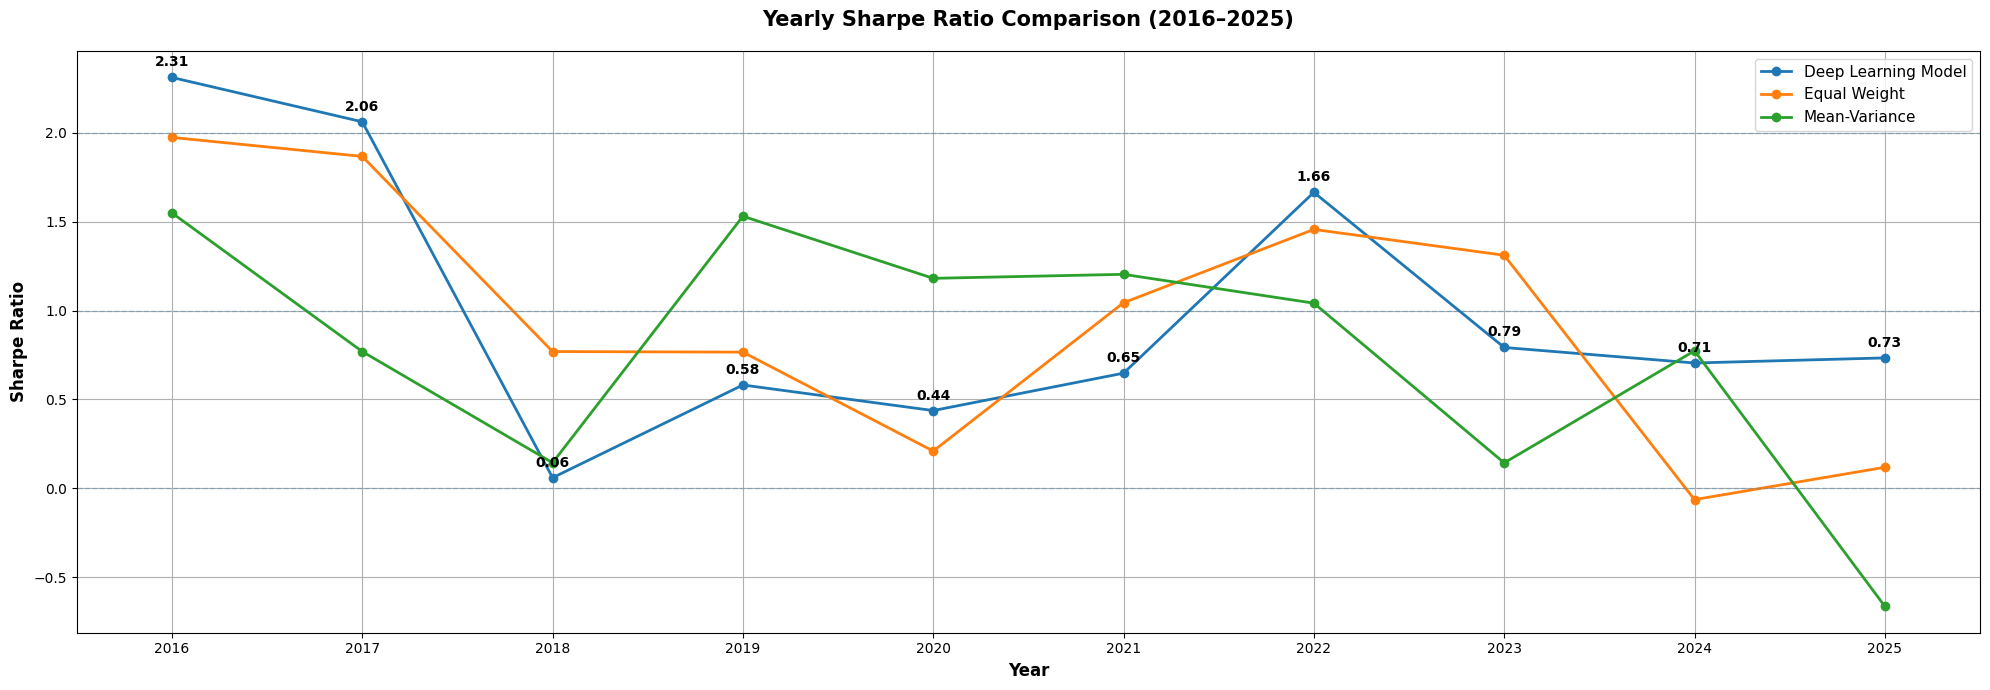

In [ ]:
df_portfolio = pd.DataFrame(portfolio_values, index=dates_history)
df_portfolio.index = pd.to_datetime(df_portfolio.index)
df_daily_returns = df_portfolio.pct_change().dropna()

def calculate_yearly_sharpe(group):
    ann_return = group.mean() * 252
    ann_vol = group.std() * np.sqrt(252)
    return ann_return / (ann_vol + 1e-8)

yearly_sharpe = df_daily_returns.groupby(df_daily_returns.index.year).apply(calculate_yearly_sharpe)
yearly_sharpe = yearly_sharpe.loc[2016:2025]
plt.figure(figsize=(20, 7), facecolor="white")
years = yearly_sharpe.index.astype(int)
plt.plot(years, yearly_sharpe["Model"], marker="o", linewidth=2, label="Deep Learning Model", color="#1f77b4")
plt.plot(years, yearly_sharpe["EqualWeight"], marker="o", linewidth=2, label="Equal Weight", color="#ff7f0e")
plt.plot(years, yearly_sharpe["MeanVariance"], marker="o", linewidth=2, label="Mean-Variance", color="#2ca02c")
y_range = yearly_sharpe["Model"].max() - yearly_sharpe["Model"].min()
offset = y_range * 0.02 if y_range != 0 else 0.1

for x, y in zip(years, yearly_sharpe["Model"]):
    plt.text(x, y + offset, f"{y:.2f}", ha="center", va="bottom", fontsize=10, fontweight="bold")

plt.title("Yearly Sharpe Ratio Comparison (2016–2025)", fontsize=15, fontweight="bold", pad=18)
plt.xlabel("Year", fontsize=12, fontweight="bold")
plt.ylabel("Sharpe Ratio", fontsize=12, fontweight="bold")
plt.xticks(range(int(min(years)), int(max(years)) + 1))
plt.xlim(min(years) - 0.5, max(years) + 0.5)

for y_line in [0, 1, 2]:
    plt.axhline(y_line, linestyle="--", linewidth=1, alpha=0.3)

plt.legend(frameon=True, fontsize=11, loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()

## **Yearly Annualized Volatility Comparison**

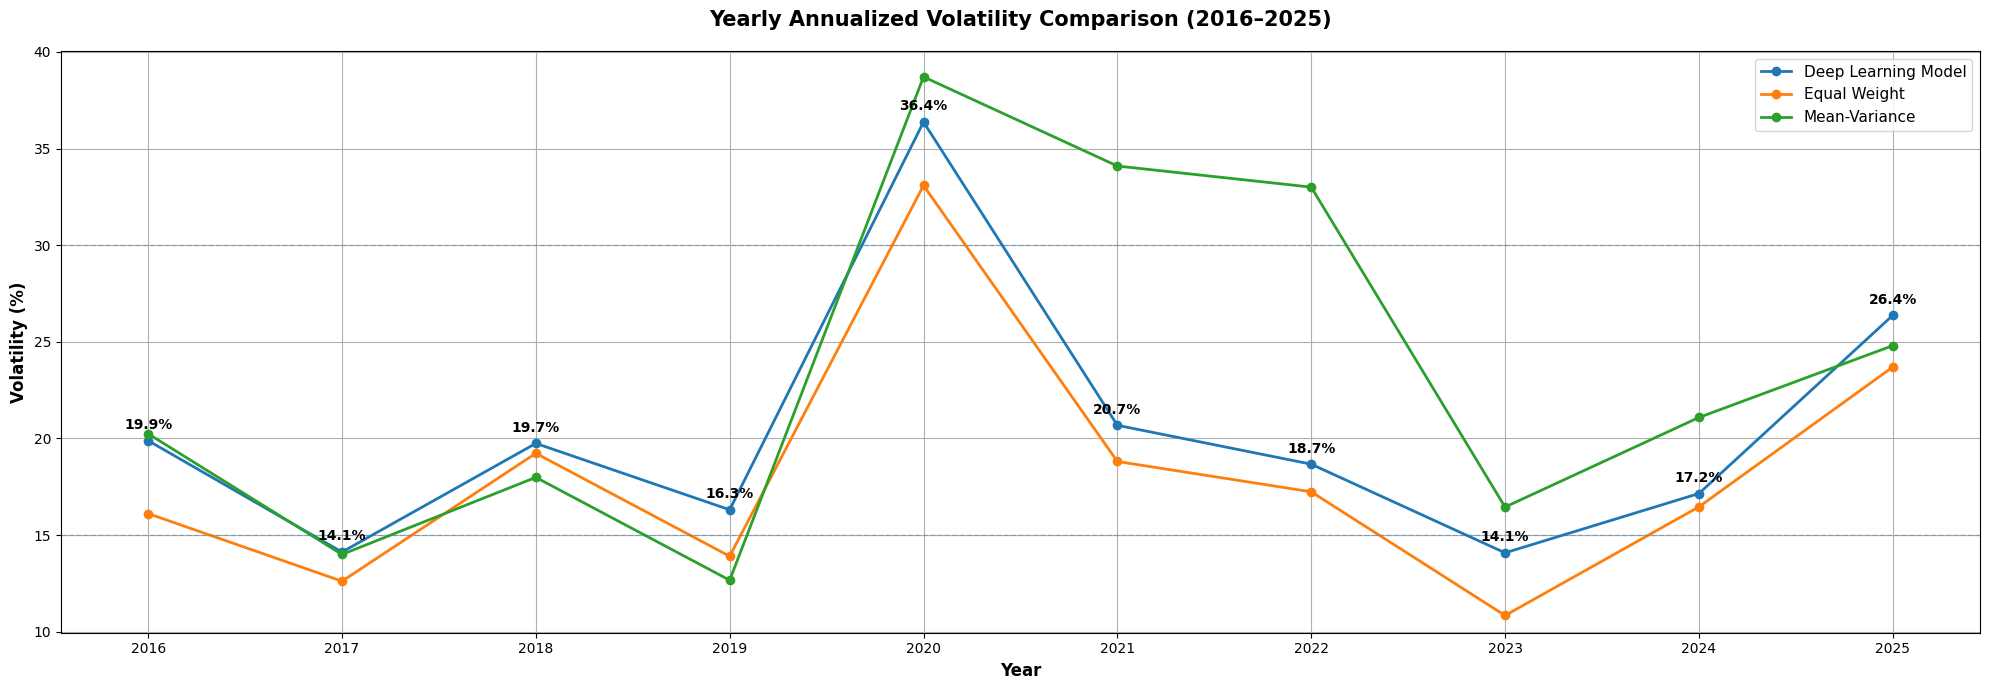

In [ ]:
df_daily_returns = results_df.pct_change().dropna()
yearly_vol = (df_daily_returns.groupby(df_daily_returns.index.year).std()* np.sqrt(252)* 100)
yearly_vol = yearly_vol.loc[2016:2025]
years = yearly_vol.index
plt.figure(figsize=(20, 7), facecolor="white")
plt.plot(years,yearly_vol["Model"],marker="o",linewidth=2,label="Deep Learning Model")
plt.plot(years,yearly_vol["EqualWeight"],marker="o",linewidth=2,label="Equal Weight")
plt.plot(years,yearly_vol["MeanVariance"],marker="o",linewidth=2,label="Mean-Variance")
y_range = yearly_vol["Model"].max() - yearly_vol["Model"].min()
offset = y_range * 0.02 if y_range != 0 else 0.5

for x, y in zip(years, yearly_vol["Model"]):
    plt.text(x,y + offset,f"{y:.1f}%",ha="center",va="bottom",fontsize=10,fontweight="bold")

for y in [15, 30]:
    plt.axhline(y, linestyle="--", linewidth=1, alpha=0.35)

plt.title("Yearly Annualized Volatility Comparison (2016–2025)", fontsize=15, fontweight="bold", pad=18)
plt.xlabel("Year", fontsize=12, fontweight="bold")
plt.ylabel("Volatility (%)", fontsize=12, fontweight="bold")
plt.xticks(years)
plt.ylim(yearly_vol.min().min() - offset * 2,yearly_vol.max().max() + offset * 3)
plt.legend(frameon=True, fontsize=11, loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()

## **Drawdown Analysis**

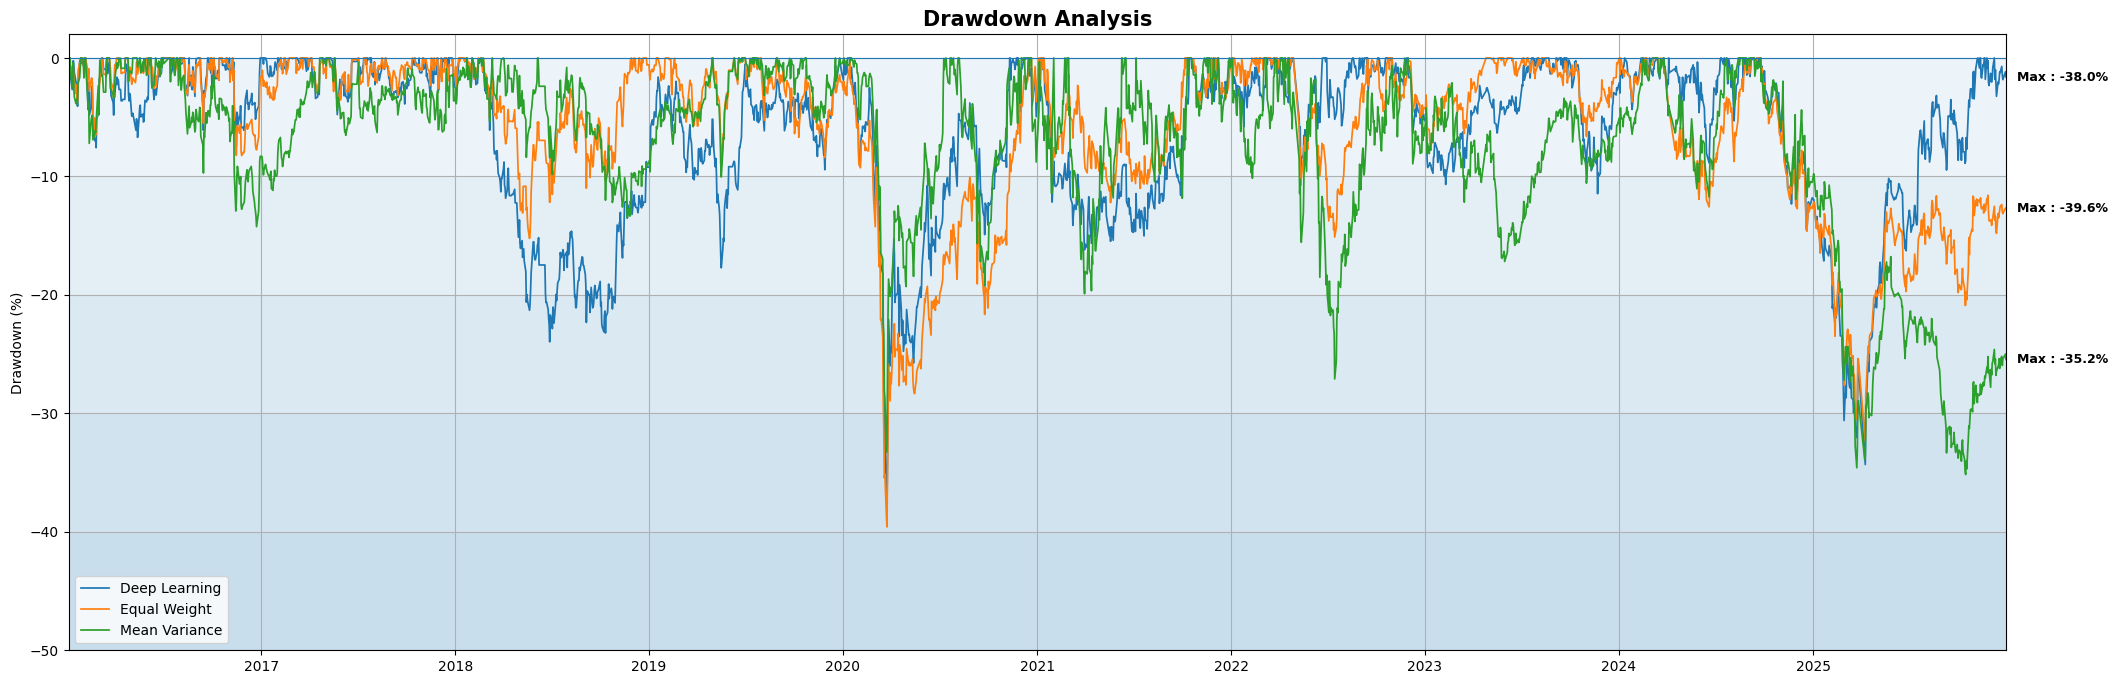

In [ ]:
strategies = {
    "Deep Learning": results_df["Model"],
    "Equal Weight": results_df["EqualWeight"],
    "Mean Variance": results_df["MeanVariance"]
}

fig, ax = plt.subplots(figsize=(25, 8))
ax.axhspan(-10, 0, alpha=0.08)
ax.axhspan(-20, -10, alpha=0.12)
ax.axhspan(-30, -20, alpha=0.16)
ax.axhspan(-40, -30, alpha=0.20)
ax.axhspan(-60, -40, alpha=0.24)

for name, equity in strategies.items():
    rolling_max = equity.cummax()
    drawdown = (equity - rolling_max) / rolling_max * 100
    ax.plot(drawdown.index,drawdown,linewidth=1.25,label=name)
    max_dd = drawdown.min()
    x_last = drawdown.index[-1]
    y_last = drawdown.iloc[-1]
    ax.annotate(f"Max : {max_dd:.1f}%",xy=(x_last, y_last),xytext=(8, 0),textcoords="offset points",va="center",ha="left",fontsize=9,fontweight="bold")

ax.axhline(0, linewidth=0.8)
ax.set_xlim(results_df.index[0], results_df.index[-1])
ax.margins(x=0)
ax.set_title("Drawdown Analysis", fontsize=15, fontweight="bold")
ax.set_ylabel("Drawdown (%)")
ax.set_ylim(-50, 2)
ax.legend()
ax.grid(True)
plt.show()

# **Portfolio Analysis: Return vs Risk vs Efficiency**

In [ ]:
def generate_professional_3d_plot(results_df):
    plot_data = []
    for col in results_df.columns:
        total_ret = results_df[col].iloc[-1] / results_df[col].iloc[0] - 1
        days = (results_df[col].index[-1] - results_df[col].index[0]).days
        ann_ret = ((1 + total_ret) ** (365 / max(days, 1)) - 1) * 100
        peak = results_df[col].cummax()
        dd = (results_df[col] - peak) / peak
        mdd = abs(dd.min() * 100)
        daily_rets = results_df[col].pct_change().dropna()
        sharpe = (daily_rets.mean() / (daily_rets.std() + 1e-6)) * np.sqrt(252)
        plot_data.append({
            'Strategy': col,
            'Return': ann_ret,
            'Drawdown': mdd,
            'Sharpe': sharpe
        })

    df_metrics = pd.DataFrame(plot_data)
    fig = go.Figure()

    colors = {
        'Model': '#1f77b4',
        'EqualWeight': '#7f7f7f',
        'MeanVariance': '#ff7f0e'
    }

    for _, row in df_metrics.iterrows():
        legend_label = (
            f"{row['Strategy']} | "
            f"Ret {row['Return']:.2f}% | "
            f"MDD {row['Drawdown']:.2f}% | "
            f"Sharpe {row['Sharpe']:.2f}"
        )

        fig.add_trace(go.Scatter3d(
            x=[row['Return']],
            y=[row['Drawdown']],
            z=[row['Sharpe']],
            mode='markers+text',
            name=legend_label,
            showlegend=True,
            marker=dict(size=8,color=colors.get(row['Strategy'], row['Sharpe']),colorscale='Plasma',opacity=0.95,line=dict(color='black', width=1),symbol='circle'),
            text=[f"<b>{row['Strategy']}</b><br>Return: {row['Return']:.2f}%<br>MDD: {row['Drawdown']:.2f}%<br>Sharpe: {row['Sharpe']:.2f}"],
            textposition="top center",
            textfont=dict(size=10, color="black"),
            hoverinfo='text'
        ))

    x_range = np.linspace(df_metrics['Return'].min() * 0.8, df_metrics['Return'].max() * 1.2, 60)
    y_range = np.linspace(df_metrics['Drawdown'].min() * 0.8, df_metrics['Drawdown'].max() * 1.2, 60)
    X, Y = np.meshgrid(x_range, y_range)
    Z = (X / (Y + 1e-9)) * (df_metrics['Sharpe'].mean() /(df_metrics['Return'].mean() / df_metrics['Drawdown'].mean()))

    fig.add_trace(go.Surface(
        x=X,
        y=Y,
        z=Z,
        colorscale='Viridis',
        opacity=0.25,
        showscale=True,
        colorbar=dict(
            title="Sharpe Ratio",
            thickness=15,
            len=0.6,
            x=1.08
        ),
        contours=dict(
            z=dict(
                show=True,
                usecolormap=True,
                highlightcolor="white",
                project_z=True
            )
        ),
        lighting=dict(
            ambient=0.6,
            diffuse=0.8,
            specular=0.4,
            roughness=0.4,
            fresnel=0.2
        )
    ))

    fig.update_layout(
        title=dict(
            text='Portfolio Analysis: Return, Risk & Efficiency',
            font=dict(size=22, color='black'),
            x=0.5
        ),
        scene=dict(
            xaxis_title='Annual Return (%)',
            yaxis_title='Max Drawdown (%)',
            zaxis_title='Sharpe Ratio',
            xaxis=dict(backgroundcolor="#cfcfcf", gridcolor="white", showgrid=True, zeroline=True, zerolinecolor="white"),
            yaxis=dict(backgroundcolor="#cfcfcf", gridcolor="white", showgrid=True, zeroline=True, zerolinecolor="white"),
            zaxis=dict(backgroundcolor="#cfcfcf", gridcolor="white", showgrid=True, zeroline=True, zerolinecolor="white")
        ),
        legend=dict(
            x=0.01,
            y=0.99,
            xanchor="left",
            yanchor="top",
            bgcolor="rgba(255,255,255,0.9)",
            bordercolor="black",
            borderwidth=1,
            font=dict(size=11, color="black")
        ),
        width=900,
        height=900,
        margin=dict(l=0, r=0, b=0, t=70)
    )

    fig.update_layout(scene_camera=dict(eye=dict(x=1.9, y=1.9, z=1.4)))
    fig.show()

generate_professional_3d_plot(results_df)

# **Result Deep Learning Model Strategy**

## **Portfolio Allocation per Year**

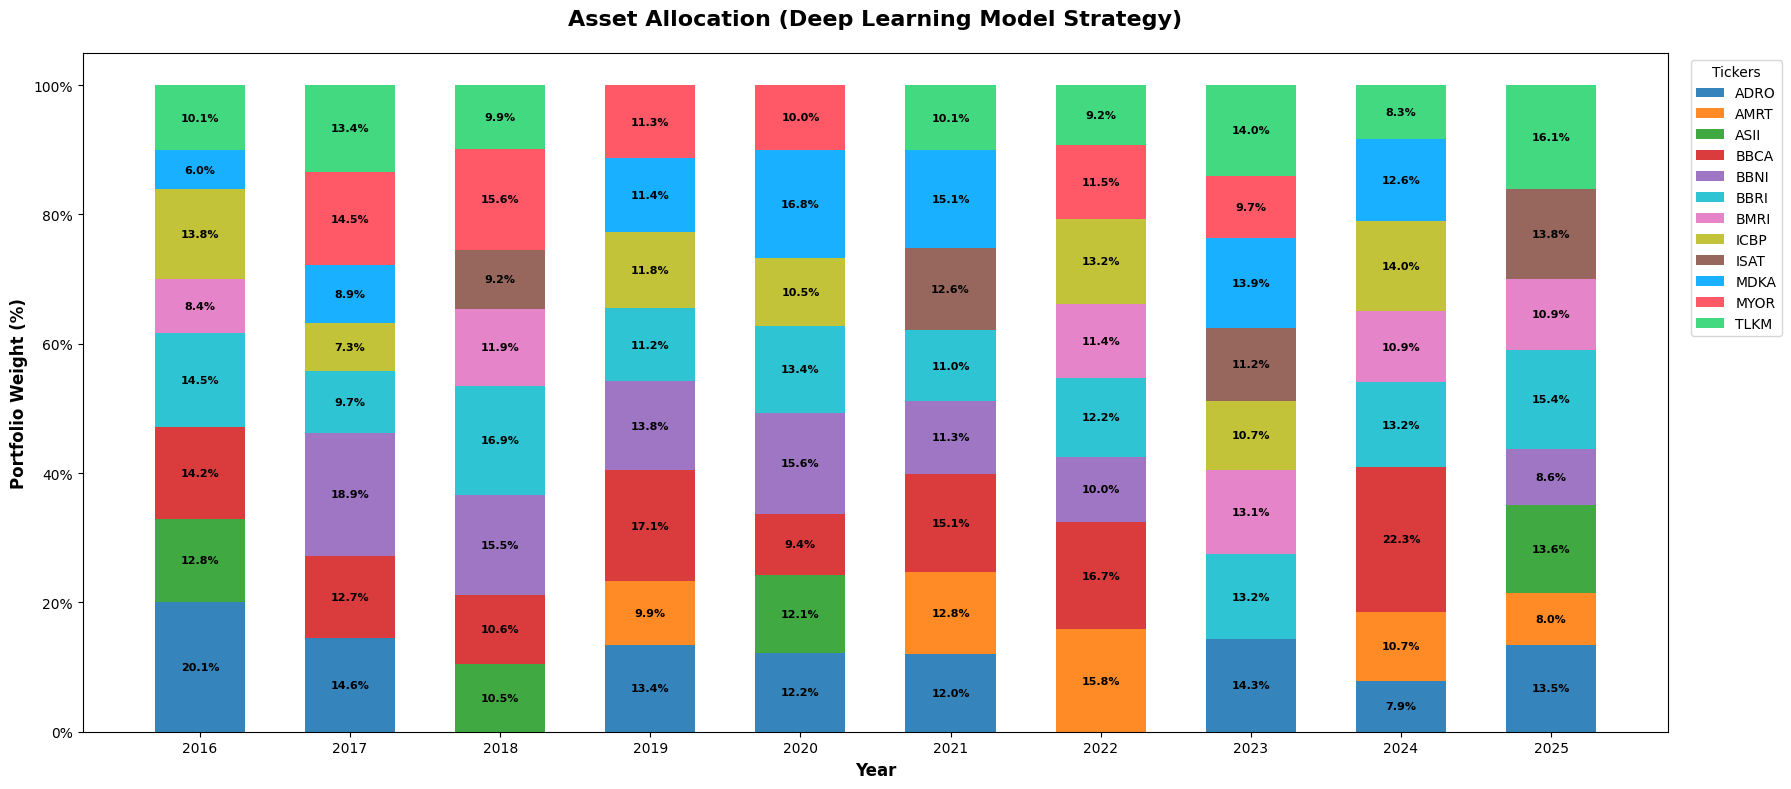

In [ ]:
yearly_weights = weights_df.groupby(weights_df.index.year).mean()
clean_yearly = {}

for year in yearly_weights.index:
    w = yearly_weights.loc[year].copy()
    w = w[w >= 0.05]

    if len(w) > 8:
        w = w.sort_values(ascending=False).iloc[:8]

    if w.sum() > 0:
        w = w / w.sum()

    clean_yearly[year] = w

clean_yearly_df = pd.DataFrame(clean_yearly).T.fillna(0)
fig, ax = plt.subplots(figsize=(18, 8), facecolor="white")
years = clean_yearly_df.index.values
bottom = np.zeros(len(years))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd','#17becf', '#e377c2', '#bcbd22', '#8c564b', '#00a8ff','#ff4757', '#2ed573']
color_idx = 0

for ticker in clean_yearly_df.columns:
    values = clean_yearly_df[ticker].values

    if np.all(values == 0):
        continue

    ax.bar(years,values,bottom=bottom,label=ticker.replace(".JK", ""),color=colors[color_idx % len(colors)],alpha=0.9,linewidth=0.5,width=0.6)

    for j, val in enumerate(values):
        if val >= 0.05:
            ax.text(years[j],bottom[j] + val / 2,f"{val * 100:.1f}%",ha="center",va="center",fontsize=8,fontweight="bold")

    bottom = bottom + values
    color_idx += 1

ax.set_title("Asset Allocation (Deep Learning Model Strategy)",fontsize=16,fontweight="bold",pad=20)
ax.set_xlabel("Year", fontsize=12, fontweight="bold")
ax.set_ylabel("Portfolio Weight (%)", fontsize=12, fontweight="bold")
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y:.0%}"))
ax.set_ylim(0, 1.05)
ax.set_xticks(years)
ax.legend(title="Tickers",bbox_to_anchor=(1.01, 1),loc="upper left",frameon=True,fontsize=10)
plt.tight_layout()
plt.show()

## **Annualized Return per Year**

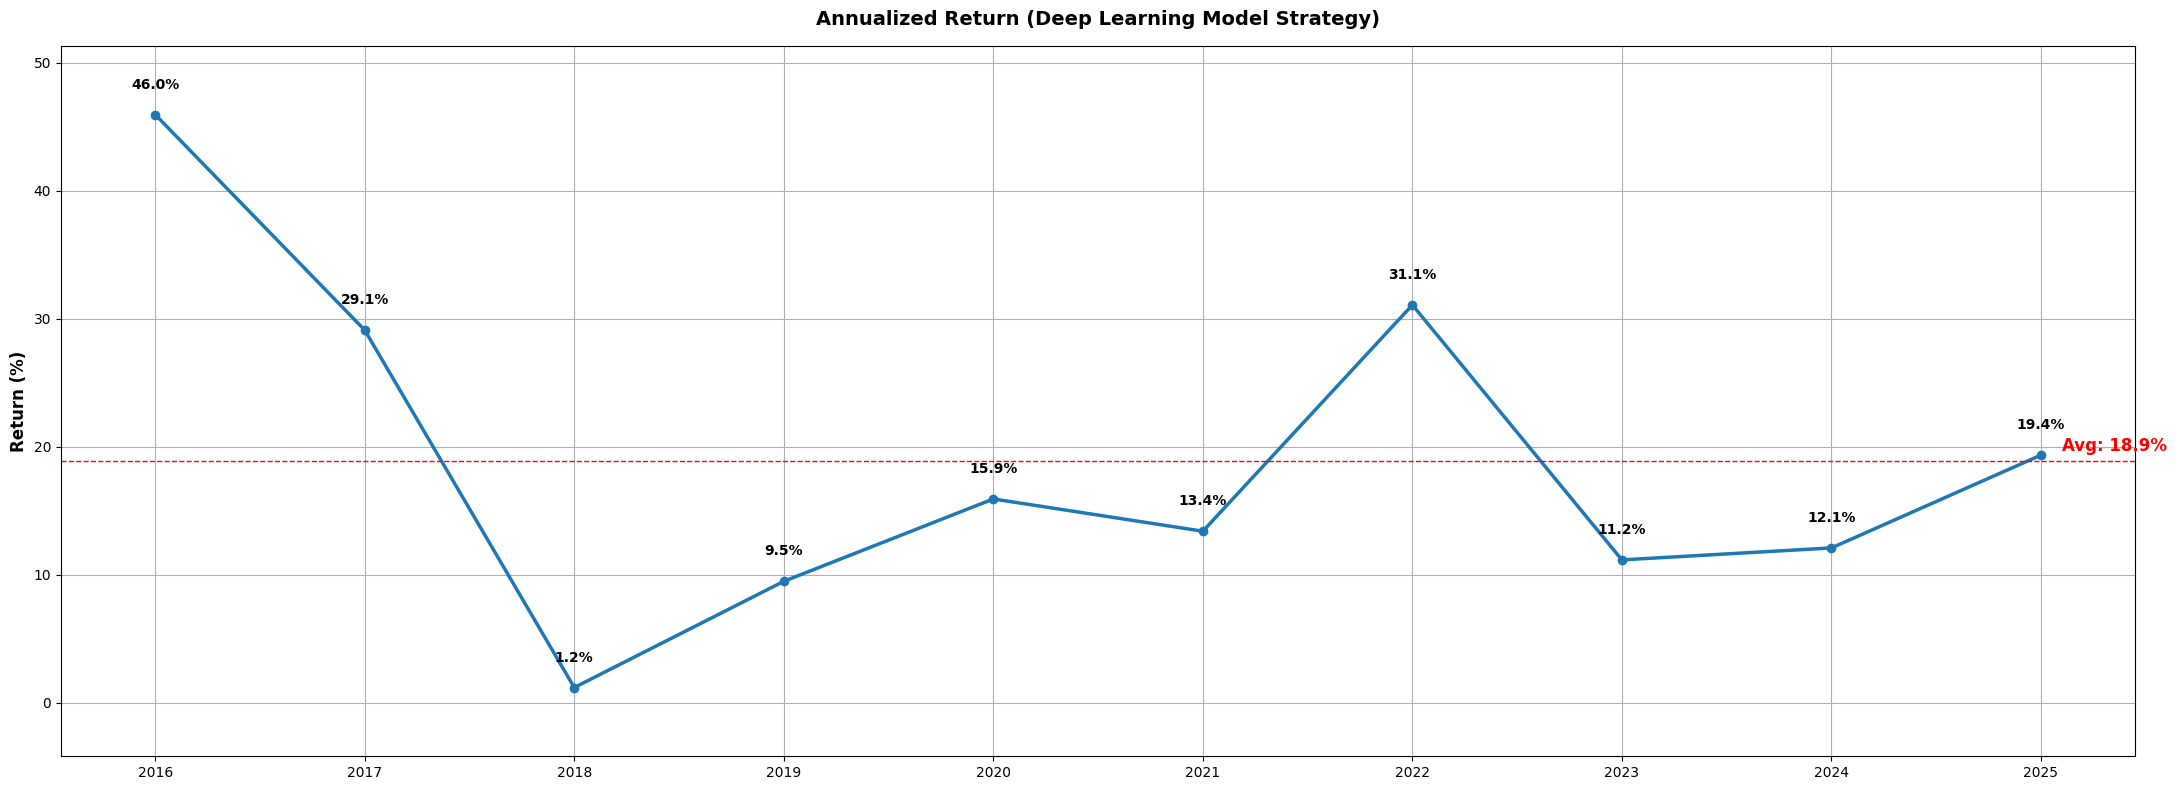

In [ ]:
daily_rets_sim = results_df.pct_change().dropna()
yearly_ann_return = daily_rets_sim.groupby(daily_rets_sim.index.year).mean() * 252
yearly_ann_vol = daily_rets_sim.groupby(daily_rets_sim.index.year).std() * np.sqrt(252)
yearly_ann_sharpe = yearly_ann_return / yearly_ann_vol
years = yearly_ann_return.index
values = yearly_ann_return["Model"] * 100
plt.figure(figsize=(22, 8), facecolor="white")
plt.plot(years, values, marker="o", linewidth=2.5, color='#1f77b4')
y_range = values.max() - values.min()
offset = y_range * 0.04 if y_range != 0 else 0.5

for x, y in zip(years, values):
    va = "bottom" if y >= 0 else "top"
    y_text = y + offset if y >= 0 else y - offset
    plt.text(x, y_text, f"{y:.1f}%", ha="center", va=va, fontsize=10, fontweight="bold")

avg_return = values.mean()
plt.axhline(avg_return, color='red', linestyle='--', linewidth=1)
offset_label = 0.5
plt.text(years[-1] + 0.1, avg_return + offset_label, f'Avg: {avg_return:.1f}%', color='red', va='bottom', fontsize=12, fontweight="bold")
plt.title("Annualized Return (Deep Learning Model Strategy)", fontsize=14, fontweight="bold", pad=15)
plt.ylabel("Return (%)", fontsize=12, fontweight="bold")
plt.xticks(years)
plt.ylim(values.min() - offset * 3, values.max() + offset * 3)
plt.grid(True)
plt.tight_layout()
plt.show()

## **Annualized Volatility per Year**

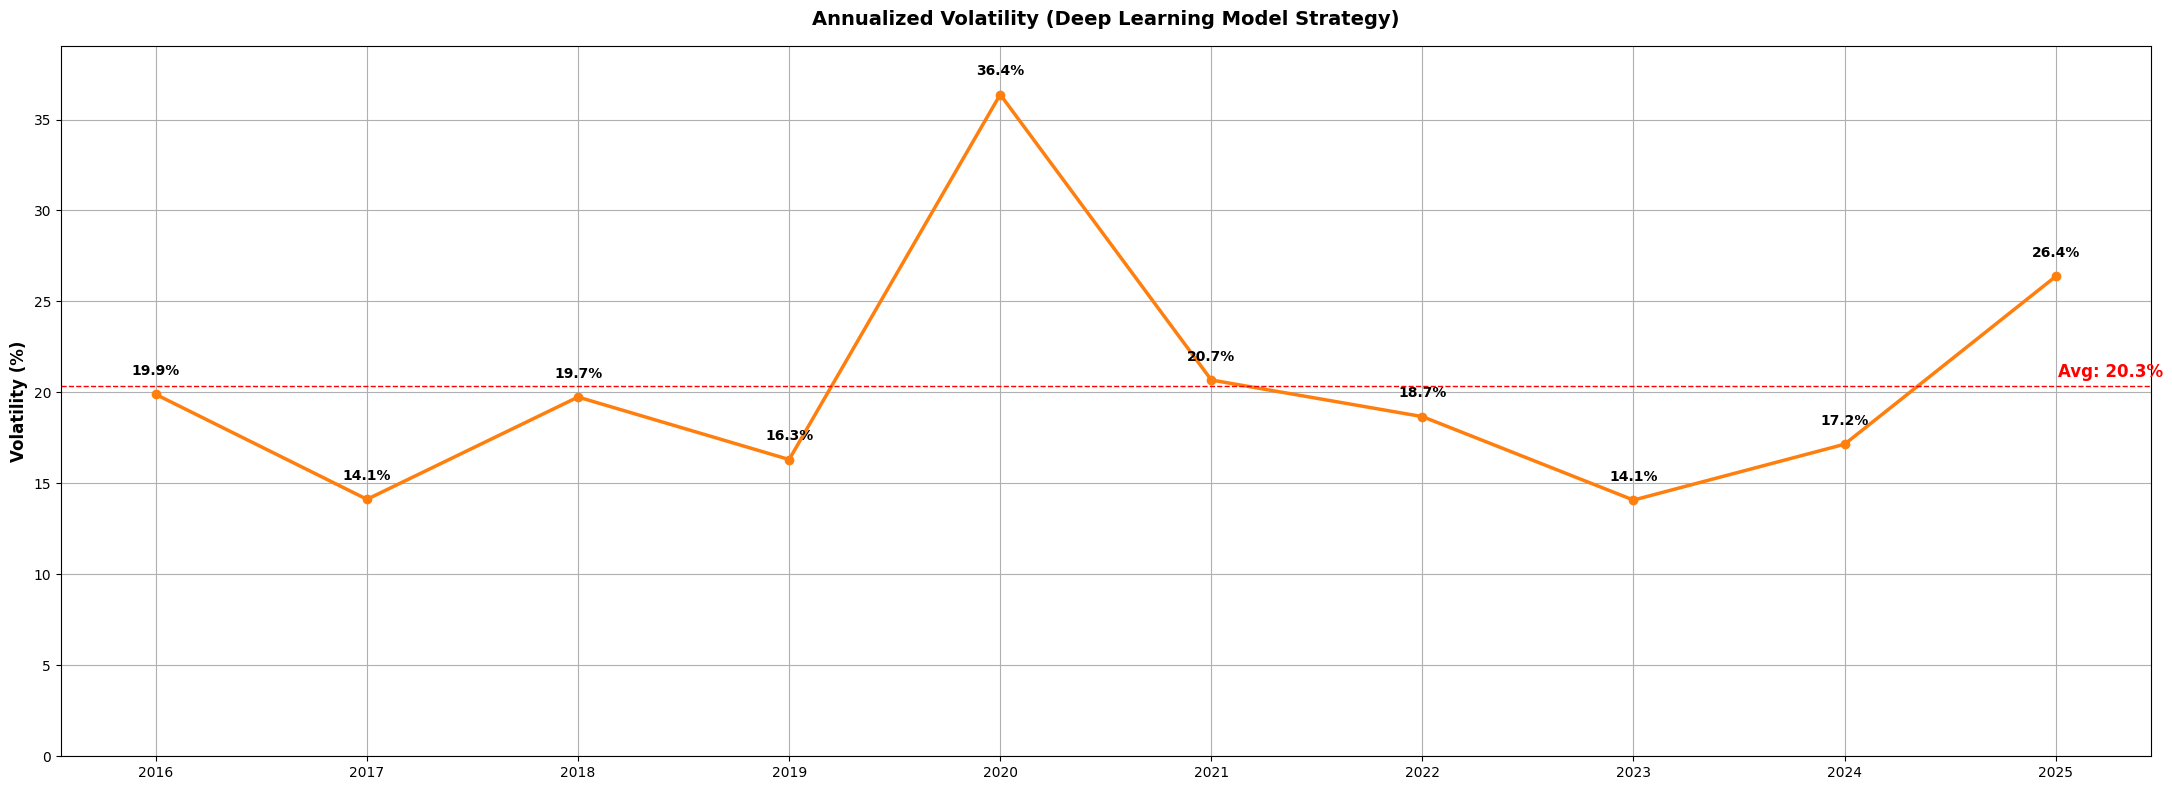

In [ ]:
values = yearly_ann_vol["Model"] * 100
years = yearly_ann_vol.index
plt.figure(figsize=(22, 8), facecolor="white")
plt.plot(years,values,marker="o",linewidth=2.5,color="#ff7f0e")
y_range = values.max() - values.min()
offset = y_range * 0.04 if y_range != 0 else 0.1

for x, y in zip(years, values):
    plt.text(x,y + offset,f"{y:.1f}%",ha="center",va="bottom",fontsize=10,fontweight="bold")

avg_value = values.mean()
plt.axhline(avg_value,color="red",linestyle="--",linewidth=1)
plt.text(years[-1] + 0.01,avg_value + offset * 0.3,f"Avg: {avg_value:.1f}%",color="red",va="bottom",fontsize=12,fontweight="bold")
plt.title("Annualized Volatility (Deep Learning Model Strategy)",fontsize=14,fontweight="bold",pad=15)
plt.ylabel("Volatility (%)", fontsize=12, fontweight="bold")
plt.xticks(years)
plt.ylim(0, values.max() + offset * 3)
plt.grid(True)
plt.tight_layout()
plt.show()

## **Annualized Sharpe Ratio**

0 = Break even

1 = Good

2 = Very Good

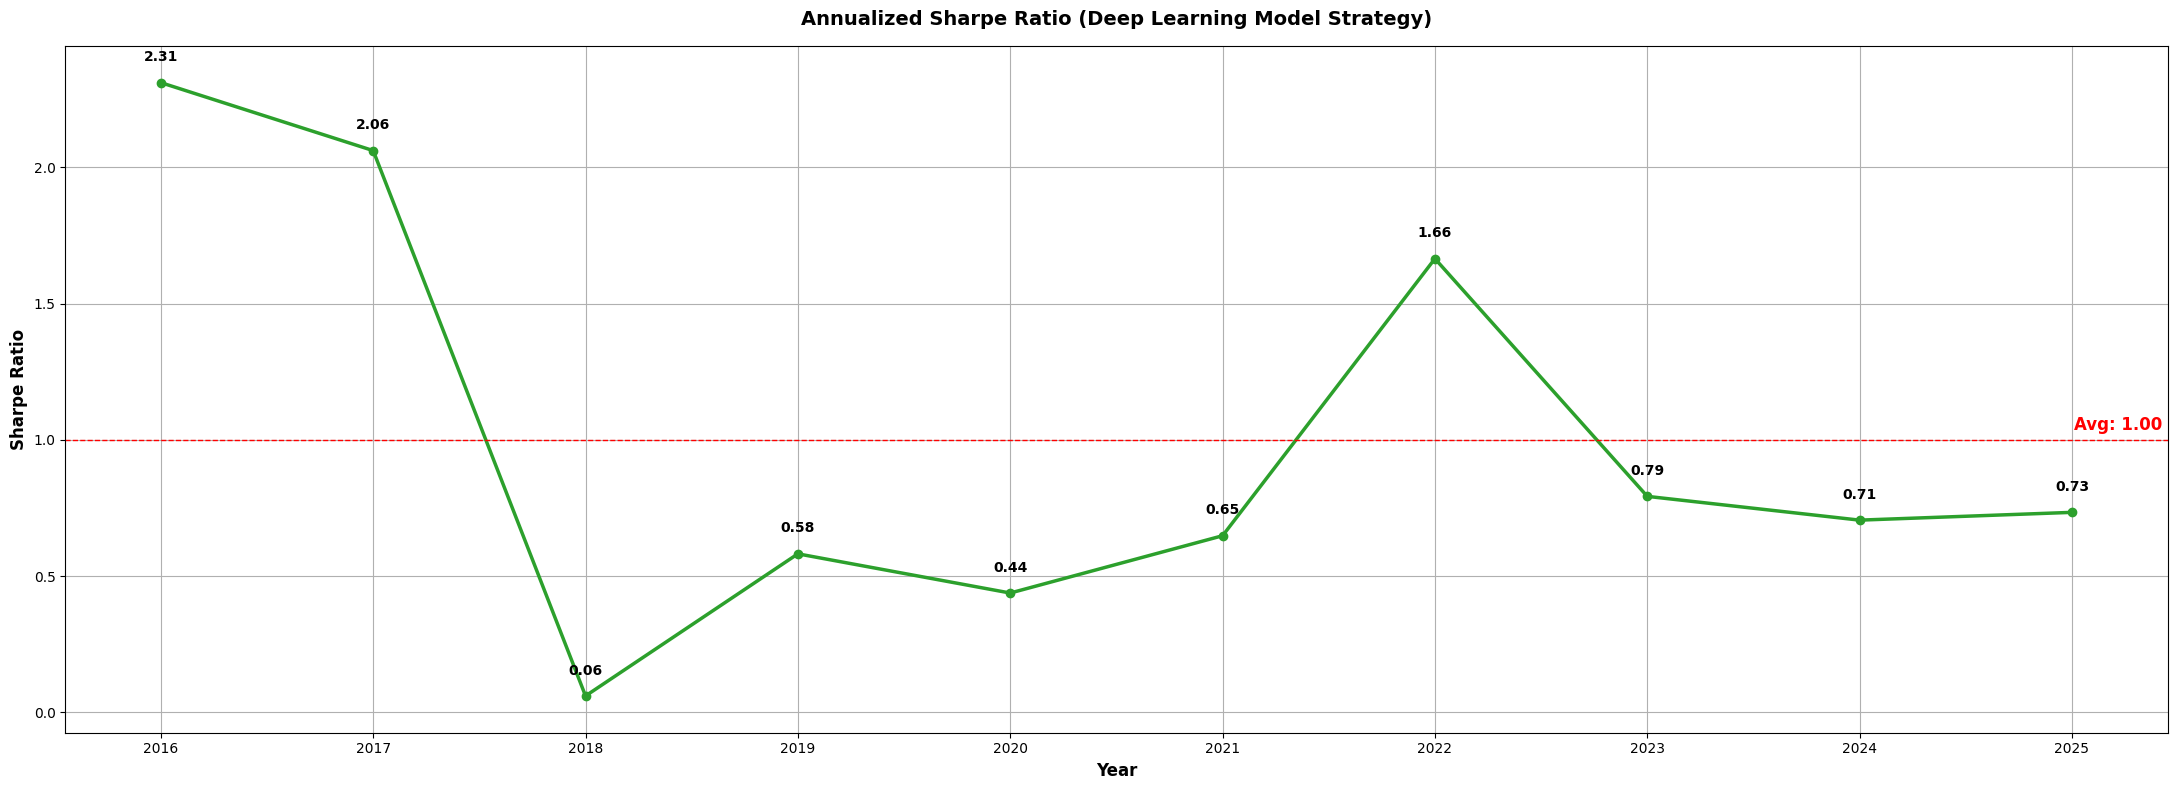

In [ ]:
values = yearly_ann_sharpe["Model"]
years = yearly_ann_sharpe.index
plt.figure(figsize=(22, 8), facecolor="white")
plt.plot(years,values,marker="o",linewidth=2.5,color="#2ca02c")
y_range = values.max() - values.min()
offset = y_range * 0.03 if y_range != 0 else 0.1

for x, y in zip(years, values):
    plt.text(x,y + offset,f"{y:.2f}",ha="center",va="bottom",fontsize=10,fontweight="bold")

avg_value = values.mean()
plt.axhline(avg_value,color="red",linestyle="--",linewidth=1)
plt.text(years[-1] + 0.01,avg_value + offset * 0.3,f"Avg: {avg_value:.2f}",color="red",va="bottom",fontsize=12,fontweight="bold")
plt.title("Annualized Sharpe Ratio (Deep Learning Model Strategy)",fontsize=14,fontweight="bold",pad=15)
plt.xlabel("Year", fontsize=12, fontweight="bold")
plt.ylabel("Sharpe Ratio", fontsize=12, fontweight="bold")
plt.xticks(years)
plt.ylim(values.min() - offset * 2, values.max() + offset * 2)
plt.grid(True)
plt.tight_layout()
plt.show()

# **Result Equal Weight Strategy**

## **Portfolio Allocation per Year**

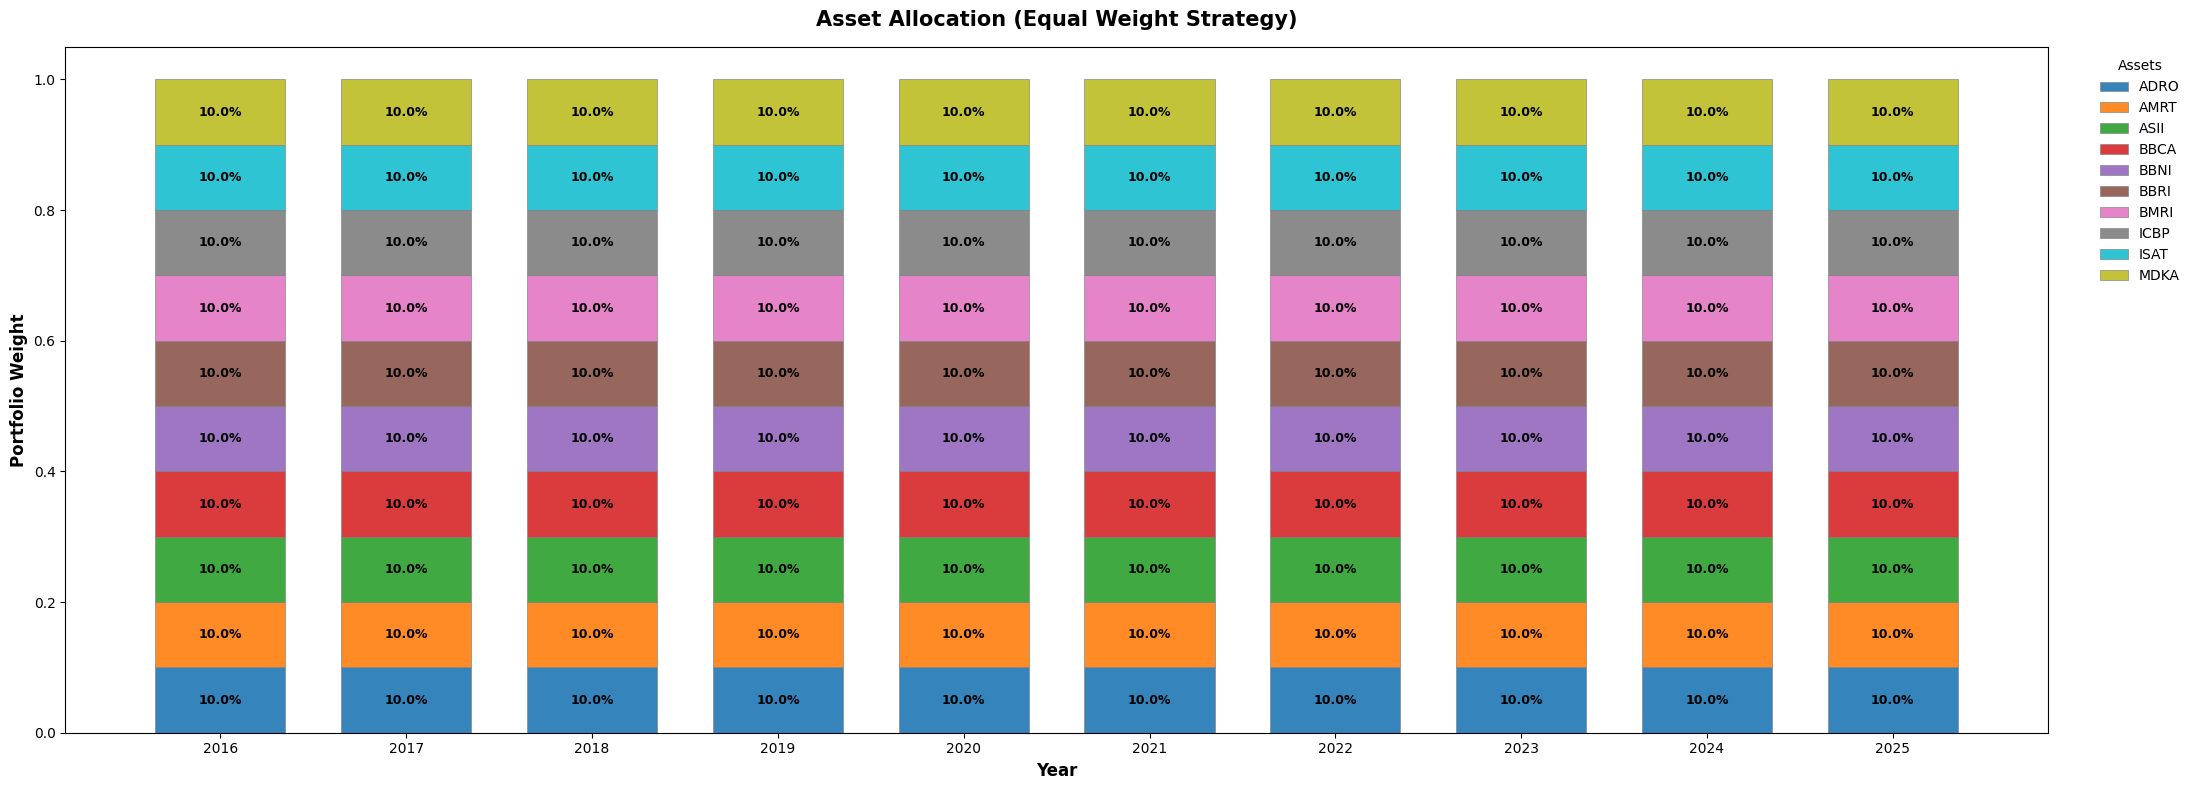

In [ ]:
num_assets = len(TICKERS)
active_assets = TICKERS[:10]
equal_weight = 1.0 / len(active_assets)
years = yearly_weights.index
ew_weights_data = {}

for ticker in TICKERS:
    name = ticker.replace(".JK", "")
    if ticker in active_assets:
        ew_weights_data[name] = [equal_weight] * len(years)
    else:
        ew_weights_data[name] = [0.0] * len(years)

yearly_ew_weights = pd.DataFrame(ew_weights_data, index=years)
fig, ax = plt.subplots(figsize=(22, 8), facecolor="white")
bottom = np.zeros(len(years))
colors_bar = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#9467bd', '#8c564b', '#e377c2', '#7f7f7f','#17becf', '#bcbd22']
color_idx = 0

for ticker in TICKERS:
    ticker_name = ticker.replace(".JK", "")
    values = yearly_ew_weights[ticker_name].values

    if np.all(values == 0):
        continue

    ax.bar(years,values,bottom=bottom,label=ticker_name,color=colors_bar[color_idx % len(colors_bar)],alpha=0.9,edgecolor="grey",linewidth=0.5,width=0.7)

    for j, val in enumerate(values):
        if val > 0:
            ax.text(years[j],bottom[j] + val / 2,f"{val*100:.1f}%",ha="center",va="center",fontsize=9,fontweight="bold")

    bottom = bottom + values.astype(float)
    color_idx += 1

ax.set_title("Asset Allocation (Equal Weight Strategy)",fontsize=15,fontweight="bold",pad=15)
ax.set_xlabel("Year", fontsize=12, fontweight="bold")
ax.set_ylabel("Portfolio Weight", fontsize=12, fontweight="bold")
ax.set_ylim(0, 1.05)
ax.set_xticks(years)
ax.legend(title="Assets",bbox_to_anchor=(1.02, 1),loc="upper left",frameon=False)
plt.tight_layout()
plt.show()

## **Annualized Return per Year**

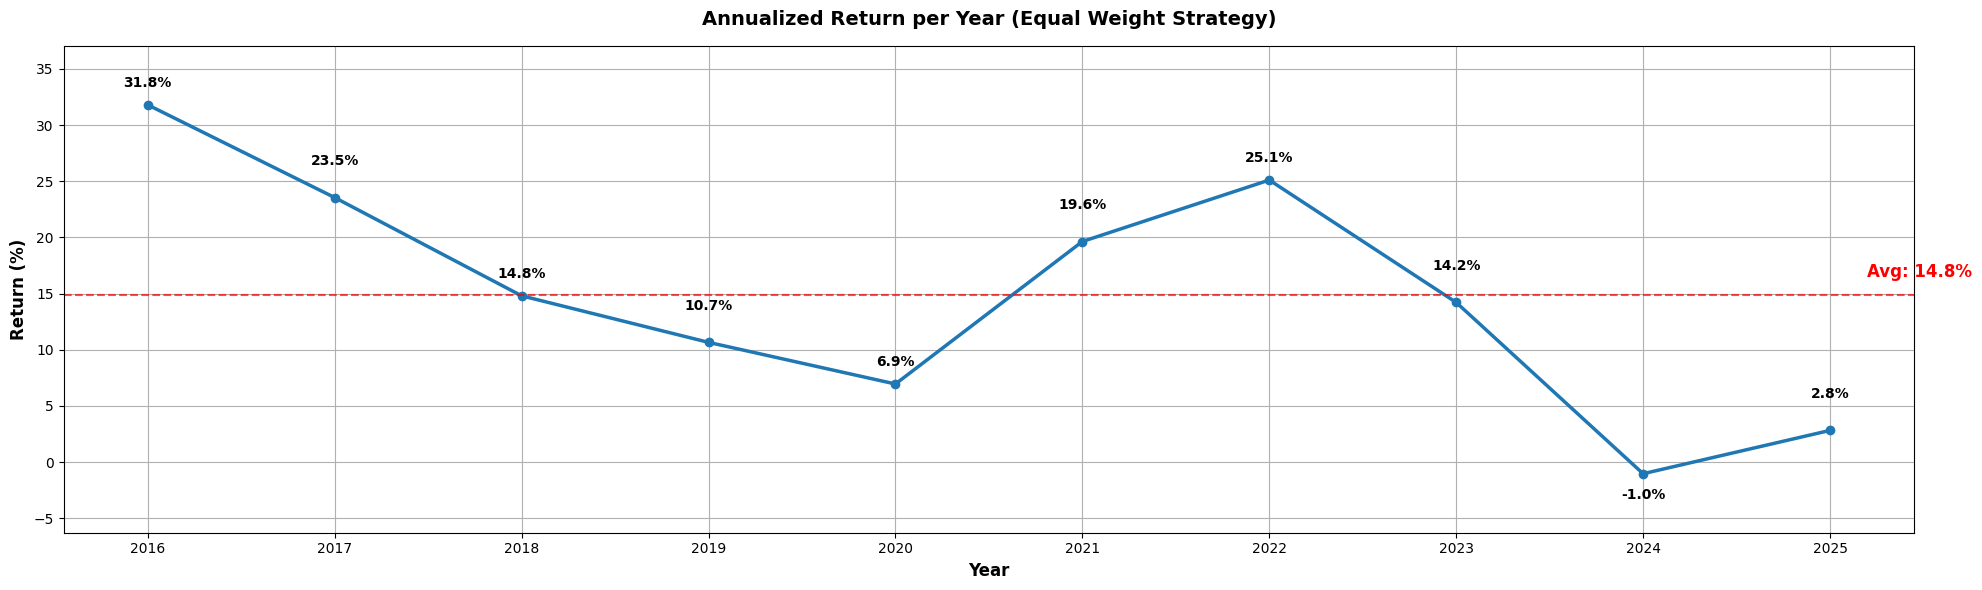

In [ ]:
values_ew = yearly_ann_return["EqualWeight"] * 100
plt.figure(figsize=(20, 6), facecolor="white")
plt.plot(years, values_ew, marker="o", linewidth=2.5, color='#1f77b4', label="Equal Weight")
y_range_ew = values_ew.max() - values_ew.min()
offset_ew = y_range_ew * 0.04 if y_range_ew != 0 else 0.5

for i, (x, y) in enumerate(zip(years, values_ew)):
    va = "bottom" if y >= 0 else "top"
    shift = offset_ew if i % 2 == 0 else offset_ew * 2
    y_text = y + shift if y >= 0 else y - shift
    plt.text(x, y_text, f"{y:.1f}%", ha="center", va=va, fontsize=10, fontweight="bold")

avg_return_ew = values_ew.mean()
plt.axhline(avg_return_ew, color='red', linestyle='--', linewidth=1.5, alpha=0.7)
plt.text(years[-1] + 0.2, avg_return_ew + offset_ew, f'Avg: {avg_return_ew:.1f}%', color='red', va='bottom', fontsize=12, fontweight="bold")
plt.title("Annualized Return per Year (Equal Weight Strategy)", fontsize=14, fontweight="bold", pad=15)
plt.ylabel("Return (%)", fontsize=12, fontweight="bold")
plt.xlabel("Year", fontsize=12, fontweight="bold")
plt.xticks(years)
plt.ylim(values_ew.min() - offset_ew * 4, values_ew.max() + offset_ew * 4)
plt.grid(True)
plt.tight_layout()
plt.show()

## **Annualized Volatility per Year**

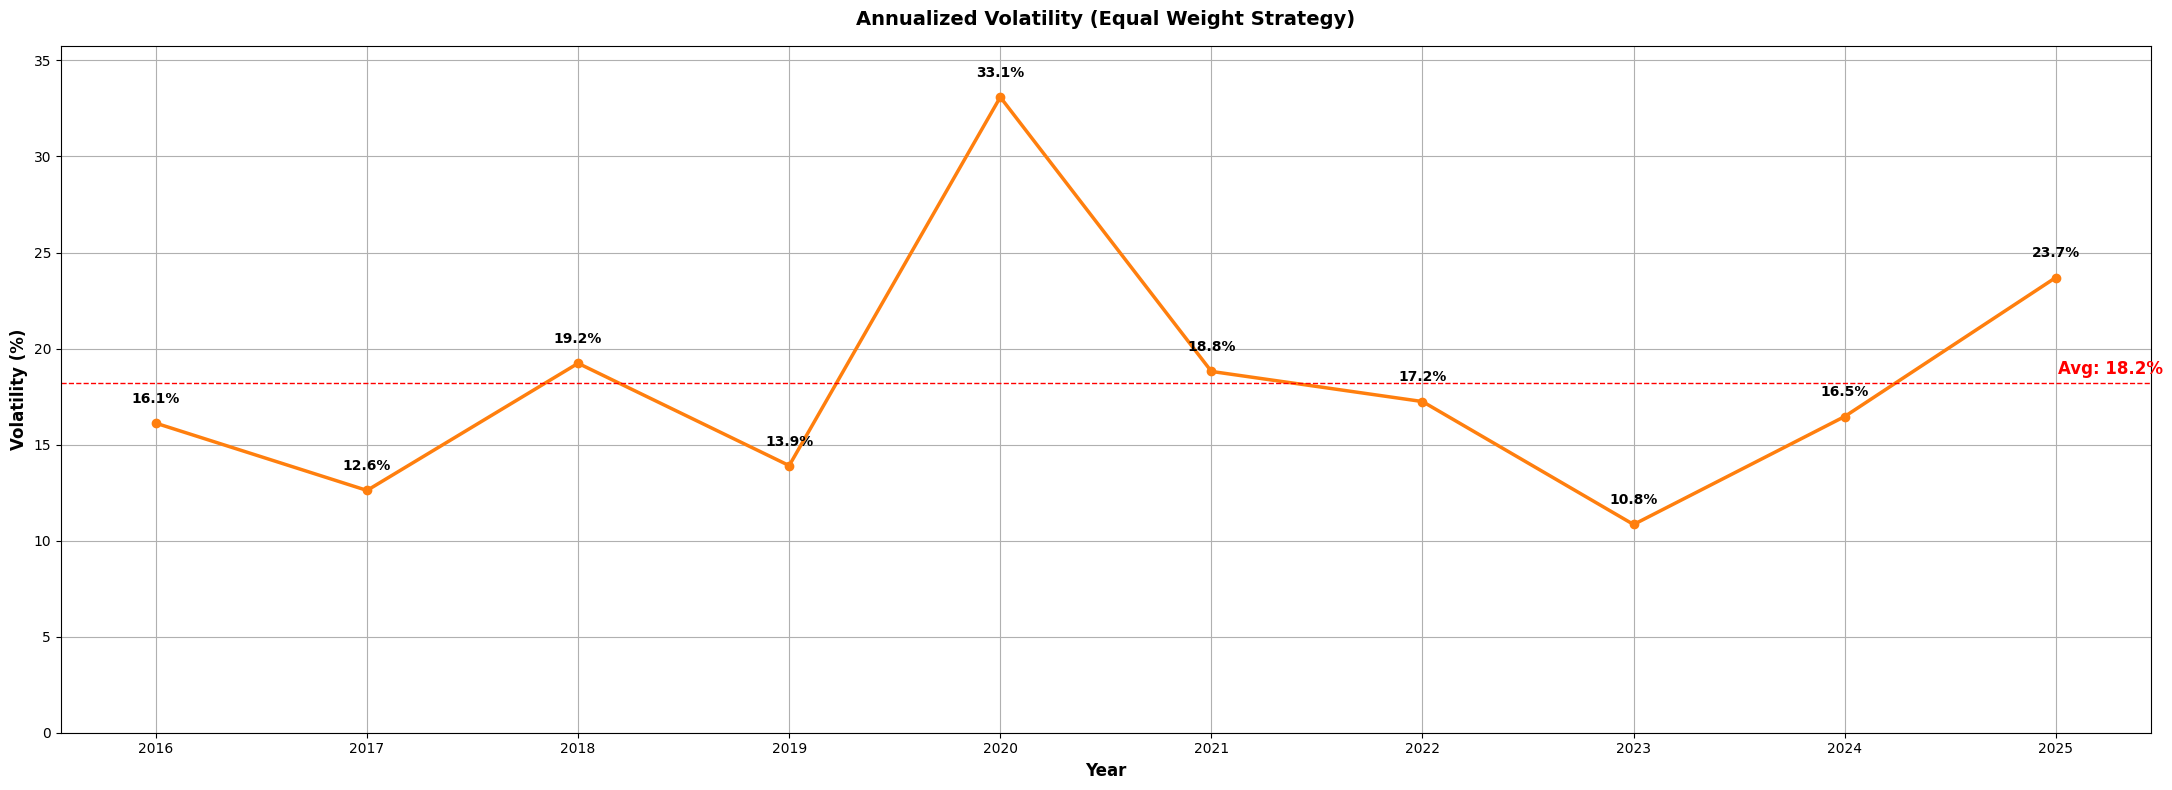

In [ ]:
values_vol_ew = yearly_ann_vol["EqualWeight"] * 100
years = yearly_ann_vol.index
plt.figure(figsize=(22, 8), facecolor="white")
plt.plot(years,values_vol_ew,marker="o",linewidth=2.5,color="#ff7f0e",label="Equal Weight")
y_range_vol = values_vol_ew.max() - values_vol_ew.min()
offset_vol = y_range_vol * 0.04 if y_range_vol != 0 else 0.5

for x, y in zip(years, values_vol_ew):
    plt.text(x,y + offset_vol,f"{y:.1f}%",ha="center",va="bottom",fontsize=10,fontweight="bold")

avg_vol_ew = values_vol_ew.mean()
plt.axhline(avg_vol_ew,color="red",linestyle="--",linewidth=1)
plt.text(years[-1] + 0.01, avg_vol_ew + offset_vol * 0.3, f"Avg: {avg_vol_ew:.1f}%", color="red", va="bottom", fontsize=12, fontweight="bold")
plt.title("Annualized Volatility (Equal Weight Strategy)",fontsize=14,fontweight="bold",pad=15)
plt.ylabel("Volatility (%)", fontsize=12, fontweight="bold")
plt.xlabel("Year", fontsize=12, fontweight="bold")
plt.xticks(years)
plt.ylim(0, values_vol_ew.max() + offset_vol * 3)
plt.grid(True)
plt.tight_layout()
plt.show()

## **Annualized Sharpe Ratio**

0 = Break even

1 = Good

2 = Very Good

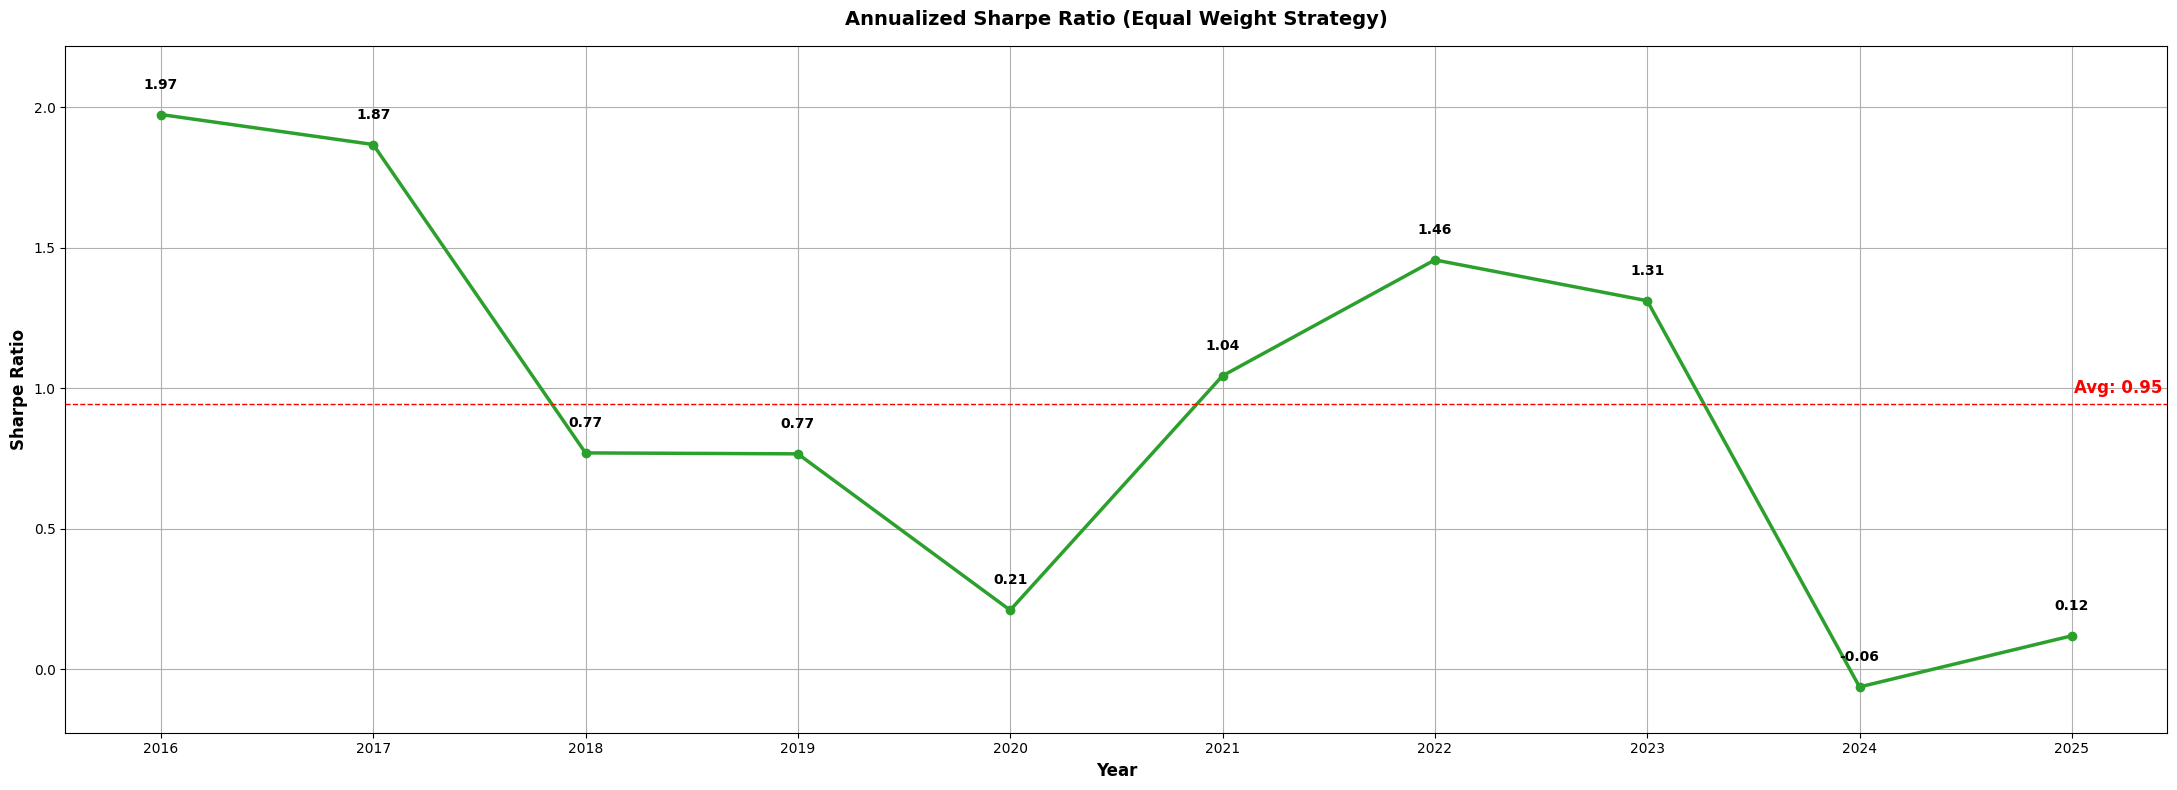

In [ ]:
values_sharpe_ew = yearly_ann_sharpe["EqualWeight"]
years = yearly_ann_sharpe.index
plt.figure(figsize=(22, 8), facecolor="white")
plt.plot(years,values_sharpe_ew,marker="o",linewidth=2.5,color="#2ca02c",label="Equal Weight")
y_range_sharpe = values_sharpe_ew.max() - values_sharpe_ew.min()
offset_sharpe = y_range_sharpe * 0.04 if y_range_sharpe != 0 else 0.1

for x, y in zip(years, values_sharpe_ew):
    plt.text(x,y + offset_sharpe,f"{y:.2f}",ha="center",va="bottom",fontsize=10,fontweight="bold")

avg_sharpe_ew = values_sharpe_ew.mean()
plt.axhline(avg_sharpe_ew,color="red",linestyle="--",linewidth=1)
plt.text(years[-1] + 0.01, avg_sharpe_ew + offset_sharpe * 0.3, f"Avg: {avg_sharpe_ew:.2f}", color="red", va="bottom", fontsize=12, fontweight="bold")
plt.title("Annualized Sharpe Ratio (Equal Weight Strategy)",fontsize=14,fontweight="bold",pad=15)
plt.xlabel("Year", fontsize=12, fontweight="bold")
plt.ylabel("Sharpe Ratio", fontsize=12, fontweight="bold")
plt.xticks(years)
plt.ylim(values_sharpe_ew.min() - offset_sharpe * 2,values_sharpe_ew.max() + offset_sharpe * 3)
plt.grid(True)
plt.tight_layout()
plt.show()

# **Result Mean Variance Strategy**

## **Portfolio Allocation per Year**

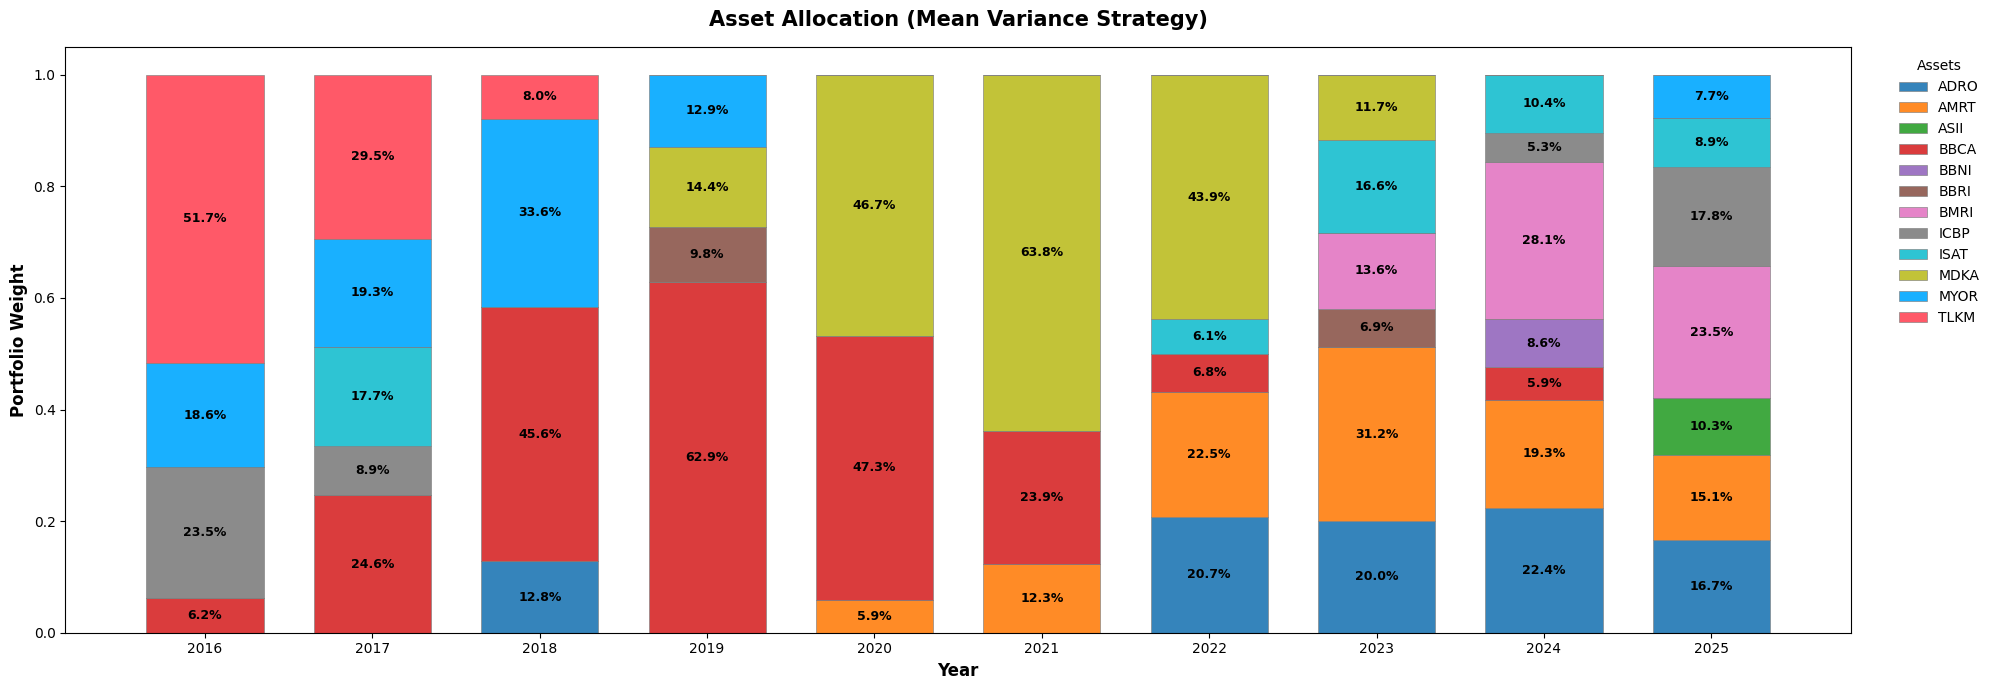

In [ ]:
mv_weights_df = pd.DataFrame(mv_weights_history,index=dates_history,columns=[t.replace(".JK", "") for t in TICKERS])
yearly_mv_weights = mv_weights_df.groupby(mv_weights_df.index.year).mean()
clean_mv = {}

for year in yearly_mv_weights.index:
    w = yearly_mv_weights.loc[year].copy()
    w[w < 0.05] = 0.0

    if (w > 0).sum() > 8:
        w = w.sort_values(ascending=False)
        w.iloc[8:] = 0.0

    if w.sum() > 0:
        w = w / w.sum()

    clean_mv[year] = w

clean_mv_df = pd.DataFrame(clean_mv).T.fillna(0)
fig, ax = plt.subplots(figsize=(20, 7), facecolor="white")
years = clean_mv_df.index
bottom = np.zeros(len(years))
colors_bar = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#9467bd', '#8c564b', '#e377c2', '#7f7f7f','#17becf', '#bcbd22', '#00a8ff', '#ff4757']

for i, ticker in enumerate(TICKERS):
    name = ticker.replace(".JK", "")
    if name not in clean_mv_df.columns:
        continue

    values = clean_mv_df[name].values

    if np.all(values == 0):
        continue

    ax.bar(years, values, bottom=bottom,label=name, color=colors_bar[i % len(colors_bar)], alpha=0.9, edgecolor="grey",linewidth=0.5,width=0.7)

    for j, val in enumerate(values):
        if val >= 0.05:
            ax.text(years[j],bottom[j] + val / 2,f"{val*100:.1f}%",ha="center",va="center",fontsize=9,fontweight="bold")

    bottom += values.astype(float)

ax.set_title("Asset Allocation (Mean Variance Strategy)",fontsize=15,fontweight="bold",pad=15)
ax.set_xlabel("Year", fontsize=12, fontweight="bold")
ax.set_ylabel("Portfolio Weight", fontsize=12, fontweight="bold")
ax.set_ylim(0, 1.05)
ax.set_xticks(years)
ax.legend(title="Assets",bbox_to_anchor=(1.02, 1),loc="upper left",frameon=False)
plt.tight_layout()
plt.show()

## **Annualized Return per Year**

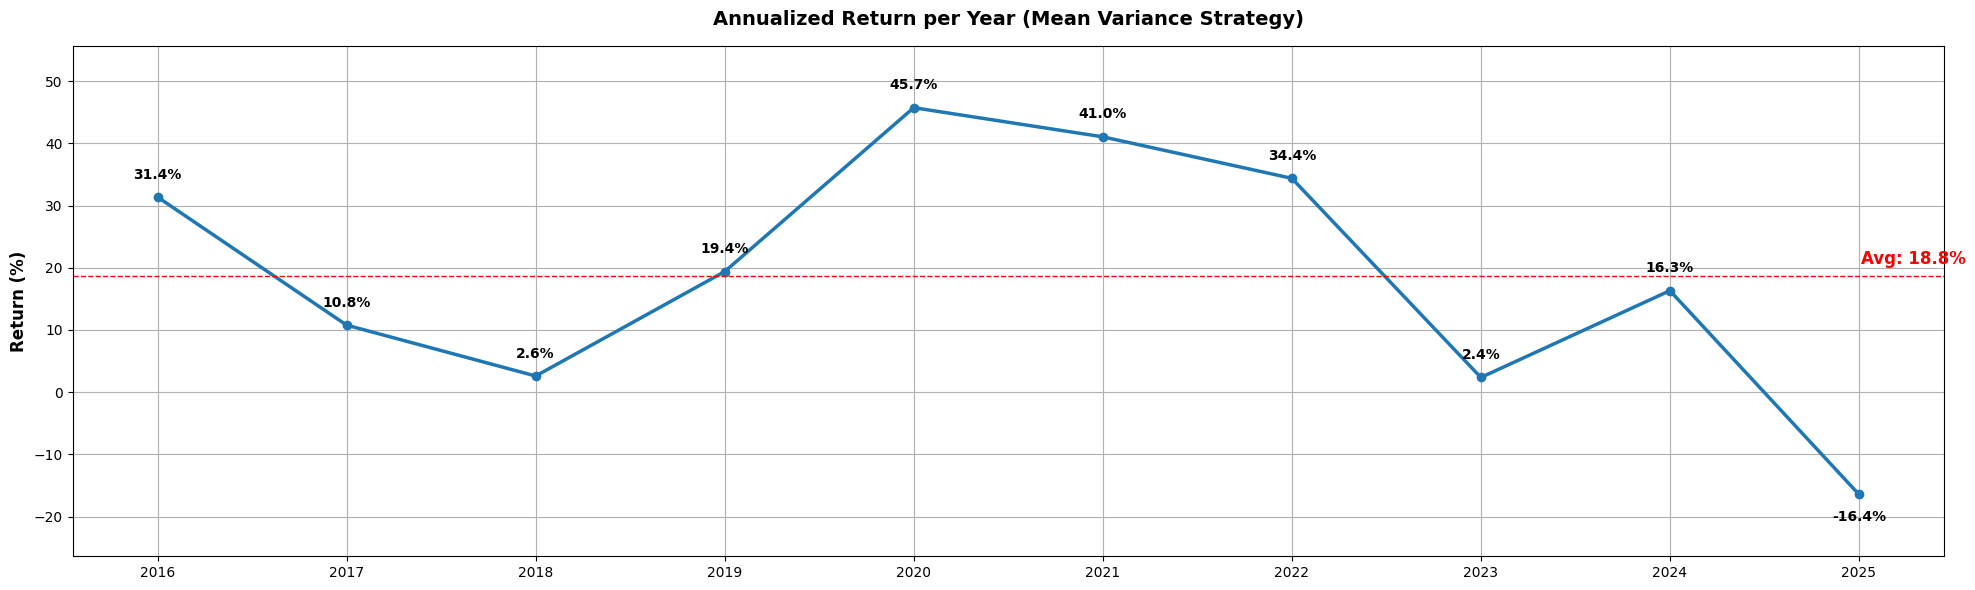

In [ ]:
daily_rets_sim = results_df.pct_change().dropna()
yearly_ann_return = daily_rets_sim.groupby(daily_rets_sim.index.year).mean() * 252
yearly_ann_vol = daily_rets_sim.groupby(daily_rets_sim.index.year).std() * np.sqrt(252)
yearly_ann_sharpe = yearly_ann_return / yearly_ann_vol
years = yearly_ann_return.index
values = yearly_ann_return["MeanVariance"] * 100
plt.figure(figsize=(20, 6), facecolor="white")
plt.plot(years, values, marker="o", linewidth=2.5, color='#1f77b4')
y_range = values.max() - values.min()
offset = y_range * 0.04 if y_range != 0 else 0.5

for x, y in zip(years, values):
    va = "bottom" if y >= 0 else "top"
    y_text = y + offset if y >= 0 else y - offset
    plt.text(x, y_text, f"{y:.1f}%", ha="center", va=va, fontsize=10, fontweight="bold")

avg_return = values.mean()
plt.axhline(avg_return, color='red', linestyle='--', linewidth=1)
offset_label = y_range * 0.02
plt.text(years[-1] + 0.01, avg_return + offset_label, f'Avg: {avg_return:.1f}%', color='red', va='bottom', fontsize=12, fontweight="bold")
plt.title("Annualized Return per Year (Mean Variance Strategy)", fontsize=14, fontweight="bold", pad=15)
plt.ylabel("Return (%)", fontsize=12, fontweight="bold")
plt.xticks(years)
plt.ylim(values.min() - offset * 4, values.max() + offset * 4)
plt.grid(True)
plt.tight_layout()
plt.show()

## **Annualized Volatility per Year**

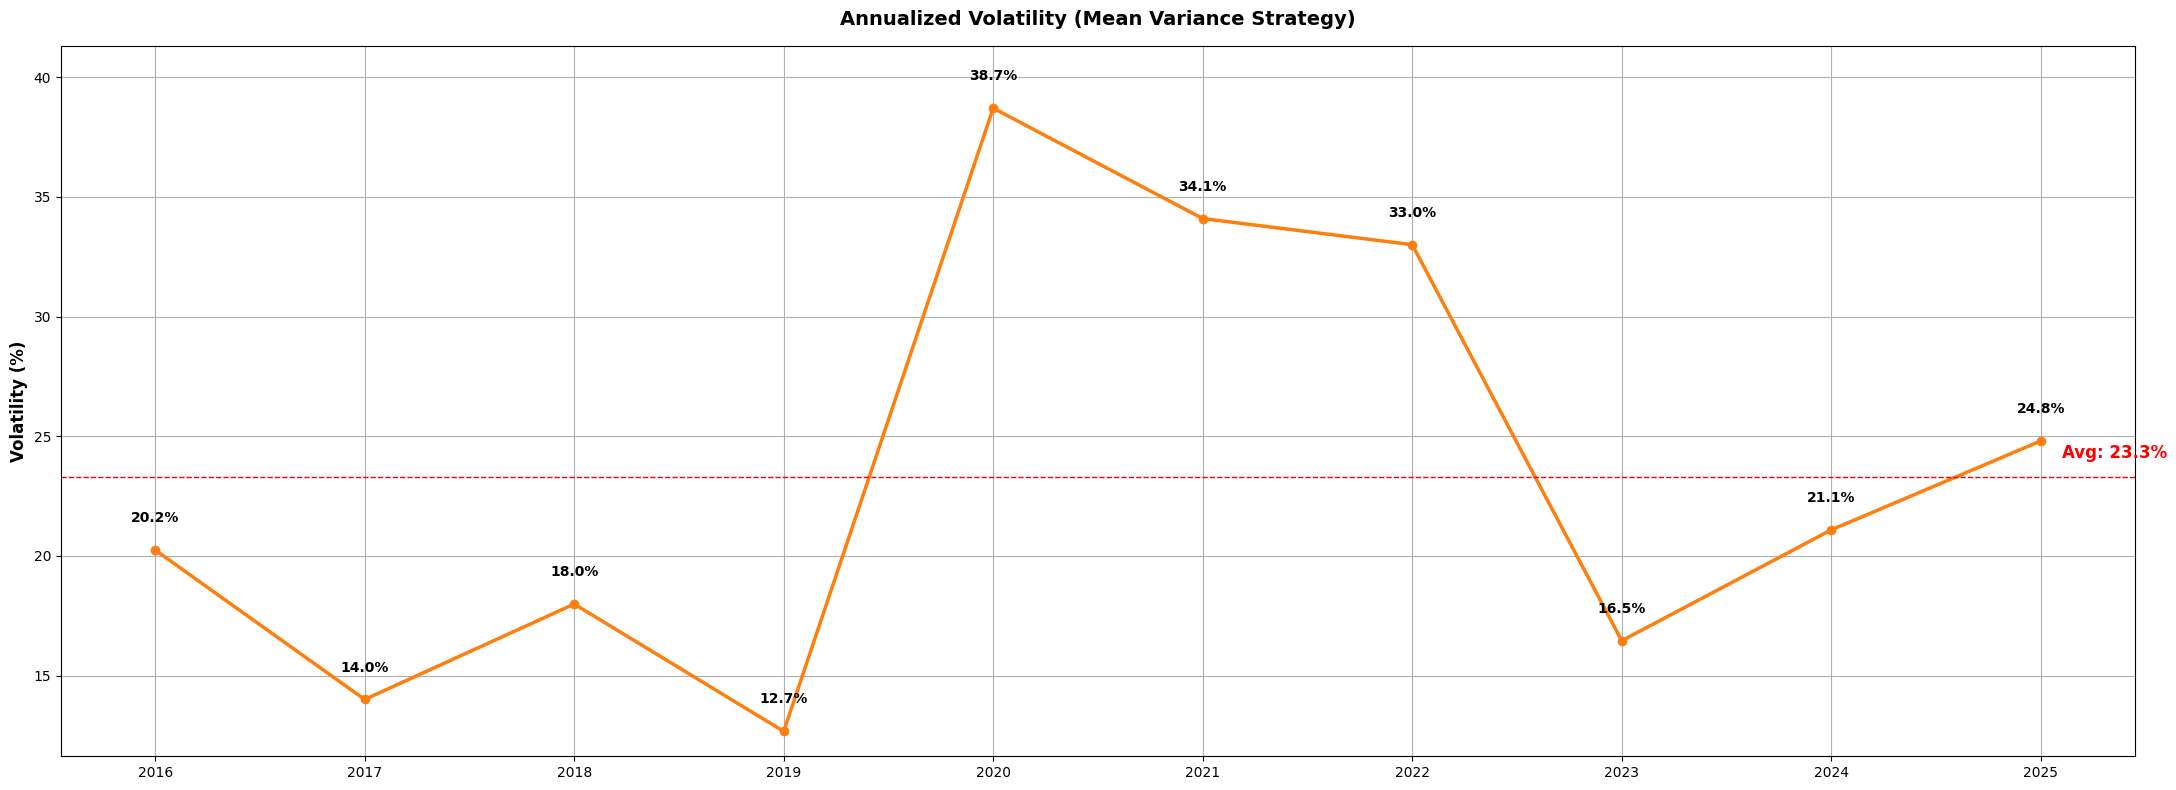

In [ ]:
values = yearly_ann_vol["MeanVariance"] * 100
plt.figure(figsize=(22, 8), facecolor="white")
plt.plot(years, values, marker="o", linewidth=2.5, color='#ff7f0e')
y_range = values.max() - values.min()
offset = y_range * 0.04 if y_range != 0 else 0.1

for x, y in zip(years, values):
    plt.text(x, y + offset, f"{y:.1f}%", ha="center", va="bottom", fontsize=10, fontweight="bold")

avg_value = values.mean()
plt.axhline(avg_value,color="red",linestyle="--",linewidth=1)
plt.text(years[-1] + 0.1,avg_value + offset * 0.6,f"Avg: {avg_value:.1f}%",color="red",va="bottom",fontsize=12,fontweight="bold")
plt.title("Annualized Volatility (Mean Variance Strategy)", fontsize=14, fontweight="bold", pad=15)
plt.ylabel("Volatility (%)", fontsize=12, fontweight="bold")
plt.xticks(years)
plt.ylim(values.min() - offset * 1, values.max() + offset * 2.5)
plt.grid(True)
plt.tight_layout()
plt.show()

## **Annualized Sharpe Ratio**

0 = Break even

1 = Good

2 = Very Good

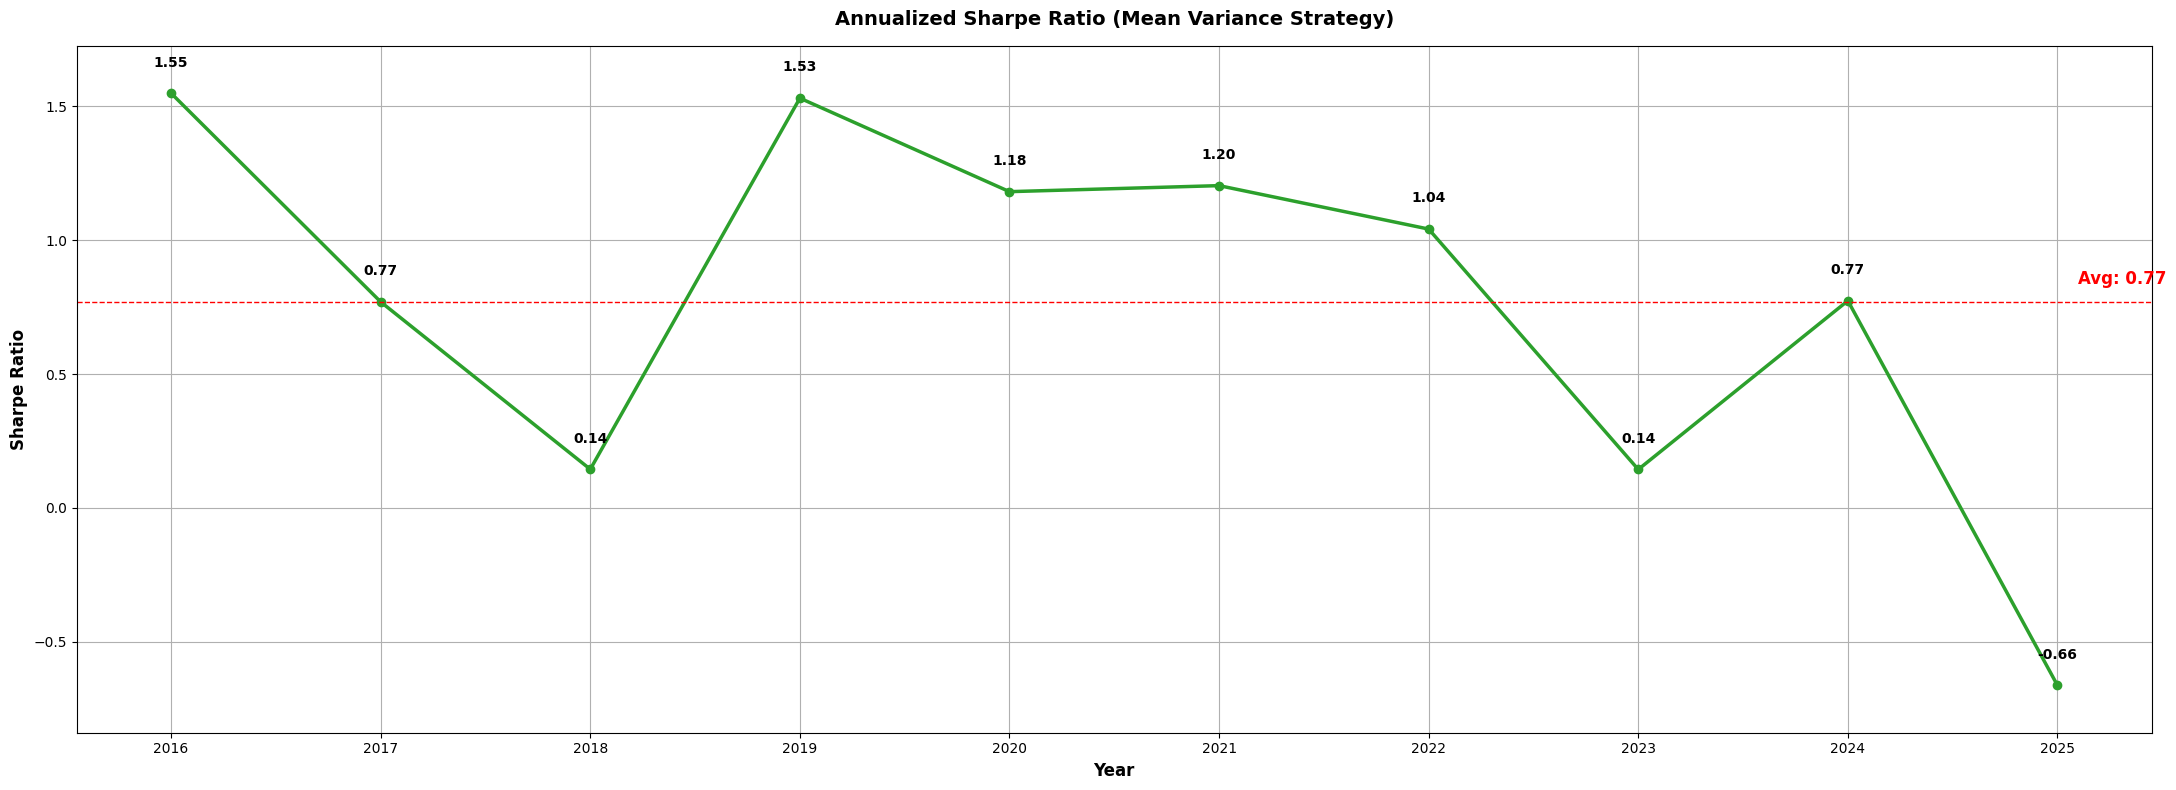

In [ ]:
values = yearly_ann_sharpe["MeanVariance"]
plt.figure(figsize=(22, 8), facecolor="white")
plt.plot(years, values, marker="o", linewidth=2.5, color='#2ca02c')
y_range = values.max() - values.min()
offset = y_range * 0.04 if y_range != 0 else 0.1

for x, y in zip(years, values):
    plt.text(x, y + offset, f"{y:.2f}", ha="center", va="bottom", fontsize=10, fontweight="bold")

avg_value = values.mean()
plt.axhline(avg_value,color="red",linestyle="--",linewidth=1)
plt.text(years[-1] + 0.1,avg_value + offset * 0.6,f"Avg: {avg_value:.2f}",color="red",va="bottom",fontsize=12,fontweight="bold")
plt.title("Annualized Sharpe Ratio (Mean Variance Strategy)", fontsize=14, fontweight="bold", pad=15)
plt.xlabel("Year", fontsize=12, fontweight="bold")
plt.ylabel("Sharpe Ratio", fontsize=12, fontweight="bold")
plt.xticks(years)
plt.ylim(values.min() - offset * 2, values.max() + offset * 2)
plt.grid(True)
plt.tight_layout()
plt.show()

# **Portfolio Allocation 2026**

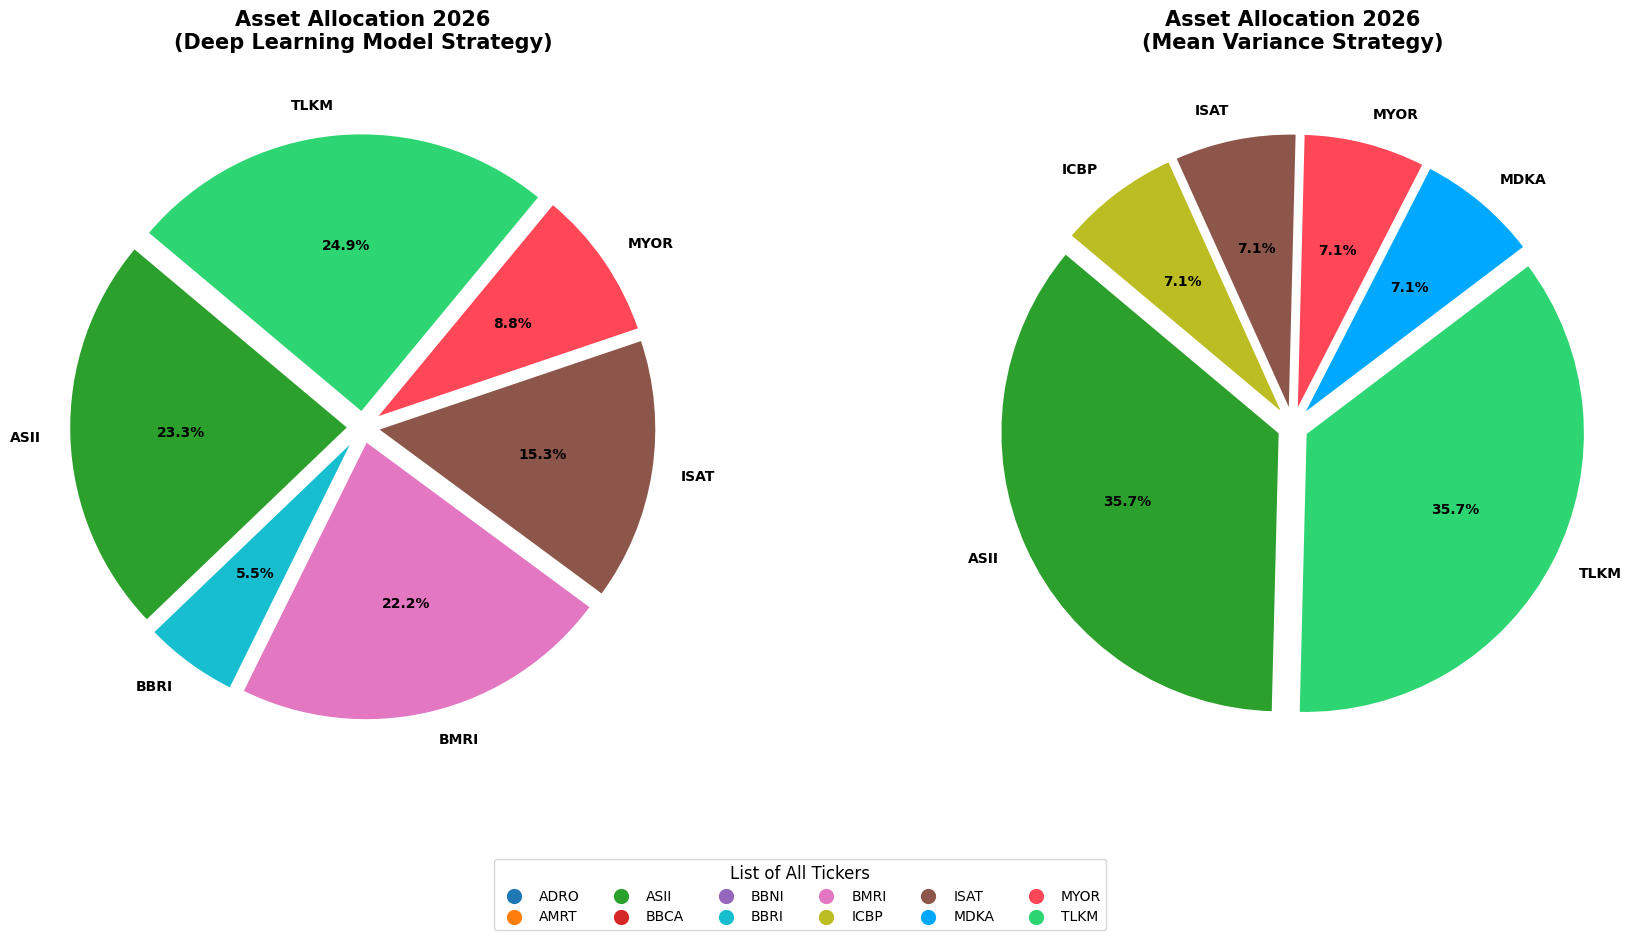

In [ ]:
labels_full = [t.replace('.JK', '') for t in TICKERS]
colors_full = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd','#17becf', '#e377c2', '#bcbd22', '#8c564b', '#00a8ff','#ff4757', '#2ed573']

def get_active_assets(weights, labels, colors):
    w = np.array(weights, dtype=float)
    w[w < 0.05] = 0.0
    active_idx = np.where(w > 0)[0]

    if len(active_idx) > 8:
        active_idx = active_idx[np.argsort(w[active_idx])[::-1][:8]]

    if len(active_idx) < 6:
        ranked_idx = np.argsort(w)[::-1]
        for i in ranked_idx:
            if i not in active_idx:
                active_idx = np.append(active_idx, i)
            if len(active_idx) >= 6:
                break

    w_active = w[active_idx]
    w_active = np.clip(w_active, 0.05, 0.25)
    w_active = w_active / w_active.sum()

    return (w_active,[labels[i] for i in active_idx],[colors[i] for i in active_idx],[0.05] * len(active_idx))

dl_w_plot, dl_l_plot, dl_c_plot, dl_e_plot = get_active_assets(dl_weights, labels_full, colors_full)
mvo_w_plot, mvo_l_plot, mvo_c_plot, mvo_e_plot = get_active_assets(mvo_weights, labels_full, colors_full)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 10), facecolor="white")

ax1.pie(dl_w_plot,labels=dl_l_plot,autopct='%1.1f%%',startangle=140,colors=dl_c_plot,explode=dl_e_plot,wedgeprops={'edgecolor': 'white', 'linewidth': 2},textprops={'weight': 'bold'})
ax1.set_title("Asset Allocation 2026\n(Deep Learning Model Strategy)",fontsize=15,fontweight='bold',pad=20)

ax2.pie(mvo_w_plot,labels=mvo_l_plot,autopct='%1.1f%%',startangle=140,colors=mvo_c_plot,explode=mvo_e_plot,wedgeprops={'edgecolor': 'white', 'linewidth': 2},textprops={'weight': 'bold'})
ax2.set_title("Asset Allocation 2026\n(Mean Variance Strategy)",fontsize=15,fontweight='bold',pad=20)

legend_elements = [
    plt.Line2D([0], [0],marker='o',color='w',label=labels_full[i],markerfacecolor=colors_full[i],markersize=12)
    for i in range(len(labels_full))]

fig.legend(handles=legend_elements,loc='lower center',ncol=6,title="List of All Tickers",title_fontsize=12,fontsize=10,bbox_to_anchor=(0.5, 0.02))
plt.subplots_adjust(bottom=0.18)
plt.show()

# **Annual Portfolio Return Expectations**

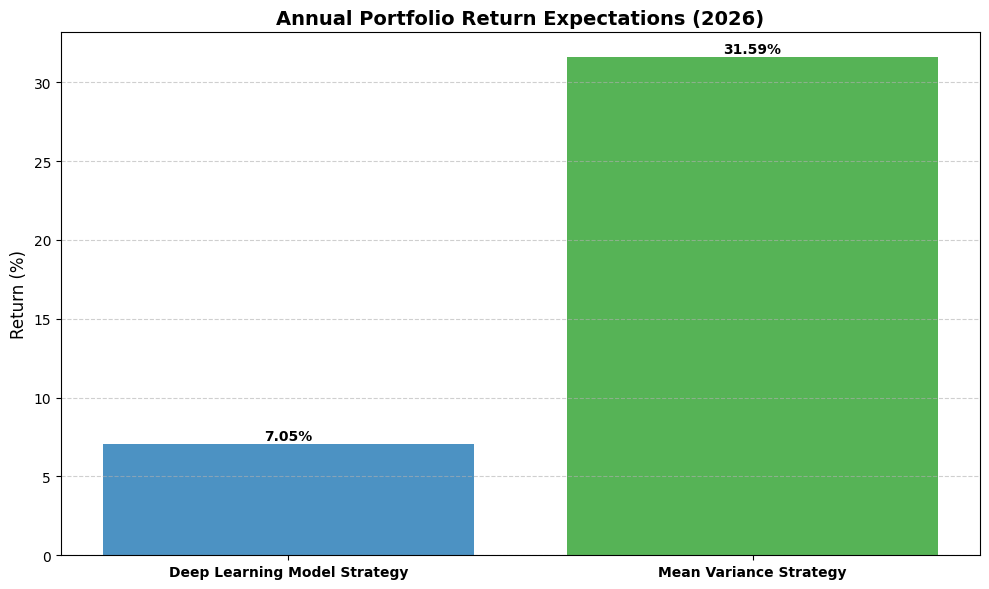

In [ ]:
expected_return_dl = np.dot(dl_weights, mu_assets)
expected_return_mvo = np.dot(mvo_weights, mu_assets)

models = ['Deep Learning Model Strategy', 'Mean Variance Strategy']
returns = [expected_return_dl * 100, expected_return_mvo * 100]

plt.figure(figsize=(10, 6), facecolor="white")
bars = plt.bar(models, returns, color=['#1f77b4', '#2ca02c'], alpha=0.8)
plt.title("Annual Portfolio Return Expectations (2026)", fontsize=14, fontweight='bold')
plt.ylabel("Return (%)", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)

for bar, ret in zip(bars, returns):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.1,f'{ret:.2f}%', ha='center', va='bottom', fontweight='bold')

plt.xticks(fontweight='bold')
plt.tight_layout()
plt.show()